In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error 

## Data Load & Set Up

In [2]:
# Import CSV files
agShare_df = pd.read_csv('Data_to_Test/agriculture-share-gdp.csv')
emissions_df = pd.read_csv('Data_to_Test/co2_emissions_kt_by_country.csv')
pesticide_df = pd.read_csv('Data_to_Test/pesticide-use-tonnes.csv')
population_df = pd.read_csv('Data_to_Test/population.csv')
gdp_df = pd.read_csv('Data_to_Test/national-gdp-penn-world-table.csv')
#crop_yield_df = pd.read_csv('https://catalog.ourworldindata.org/explorers/agriculture/latest/crop_yields/crop_yields.csv')

In [3]:
# Merge the dataframes
df = pd.merge(emissions_df, pesticide_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "country_name": "country",
    "value": "co2_emissions",
    "Pesticides (total) | 00001357 || Agricultural Use | 005157 || Tonnes": "pesticide_by_tonnes"
})
df = pd.merge(df, agShare_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "Agriculture, forestry, and fishing, value added (% of GDP)": "ag_percent_gdp"
})
df = pd.merge(df, population_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "Population (historical)": "population"
})
df = pd.merge(df, gdp_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "GDP (output, multiple price benchmarks)": "gdp"
})
#df = pd.merge(df, crop_yield_df, on = ['country', 'year'])

# Print information about the merged dataframe and the head of the datafram
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4597 entries, 0 to 5086
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_code         4597 non-null   object 
 1   country              4597 non-null   object 
 2   year                 4597 non-null   int64  
 3   co2_emissions        4597 non-null   float64
 4   pesticide_by_tonnes  4597 non-null   float64
 5   ag_percent_gdp       4597 non-null   float64
 6   population           4597 non-null   int64  
 7   gdp                  4597 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 323.2+ KB


country_code country  year  co2_emissions  pesticide_by_tonnes  \
0          ABW   Aruba  1995        707.731               231.75   
1          ABW   Aruba  1996        726.066               252.64   
2          ABW   Aruba  1997        759.069               273.52   
3          ABW   Aruba  1998        806.740               294.41   
4          ABW   Aruba  1999        810.407               315.30   

   ag_percent_gdp  population           gdp  
0        0.505922       75931  4.184156e+09  
1        0.485830       78495  3.977093e+09  
2        0.429978       81121  4.282010e+09  
3        0.407917       83787  4.660577e+09  
4        0.383268       86482  4.854151e+09

In [4]:
df["ag_gdp"] = df["ag_percent_gdp"] * df["gdp"]
df.head()

country_code country  year  co2_emissions  pesticide_by_tonnes  \
0          ABW   Aruba  1995        707.731               231.75   
1          ABW   Aruba  1996        726.066               252.64   
2          ABW   Aruba  1997        759.069               273.52   
3          ABW   Aruba  1998        806.740               294.41   
4          ABW   Aruba  1999        810.407               315.30   

   ag_percent_gdp  population           gdp        ag_gdp  
0        0.505922       75931  4.184156e+09  2.116857e+09  
1        0.485830       78495  3.977093e+09  1.932191e+09  
2        0.429978       81121  4.282010e+09  1.841171e+09  
3        0.407917       83787  4.660577e+09  1.901128e+09  
4        0.383268       86482  4.854151e+09  1.860443e+09

## Data Exploration

In [5]:
summary = df.describe().loc[['min', '25%', '50%', '75%', 'max']]
summary

year  co2_emissions  pesticide_by_tonnes  ag_percent_gdp    population  \
min  1990.0   0.000000e+00                 0.07        0.012520  3.586800e+04   
25%  1998.0   2.270000e+03               273.52        3.083317  2.547852e+06   
50%  2006.0   1.102000e+04              1476.70        8.340969  8.481411e+06   
75%  2013.0   6.614000e+04              7808.10       18.919125  2.609509e+07   
max  2019.0   1.070722e+07            620538.00       79.042366  1.423520e+09   

              gdp        ag_gdp  
min  3.610216e+08  4.909238e+07  
25%  1.486498e+10  1.355307e+11  
50%  4.996435e+10  4.839120e+11  
75%  2.895297e+11  1.772043e+12  
max  2.059584e+13  1.536579e+14

In [6]:
cumulative = df[["country","co2_emissions","pesticide_by_tonnes","ag_percent_gdp","gdp","ag_gdp"]].groupby('country').sum()
cumulative.head()

co2_emissions  pesticide_by_tonnes  ag_percent_gdp  \
country                                                                   
Albania               9.423000e+04             10063.18      511.745810   
Algeria               2.475930e+06             96528.61      201.713975   
Angola                5.124900e+05              1296.00      178.525136   
Antigua and Barbuda   1.144000e+04              9321.64       44.261775   
Argentina             4.374320e+06           3858613.95      189.197937   

                              gdp        ag_gdp  
country                                          
Albania              6.001048e+11  1.220698e+13  
Algeria              9.384938e+12  9.016616e+13  
Angola               3.226321e+12  2.362492e+13  
Antigua and Barbuda  3.370876e+10  5.485064e+10  
Argentina            1.889823e+13  1.165785e+14

In [7]:
corr_matrix = df[["year","co2_emissions","pesticide_by_tonnes","population","ag_percent_gdp","gdp","ag_gdp"]].corr().round(2)
corr_matrix

year  co2_emissions  pesticide_by_tonnes  population  \
year                 1.00           0.05                 0.07        0.02   
co2_emissions        0.05           1.00                 0.70        0.72   
pesticide_by_tonnes  0.07           0.70                 1.00        0.52   
population           0.02           0.72                 0.52        1.00   
ag_percent_gdp      -0.20          -0.11                -0.13        0.03   
gdp                  0.10           0.93                 0.77        0.64   
ag_gdp               0.06           0.76                 0.52        0.96   

                     ag_percent_gdp   gdp  ag_gdp  
year                          -0.20  0.10    0.06  
co2_emissions                 -0.11  0.93    0.76  
pesticide_by_tonnes           -0.13  0.77    0.52  
population                     0.03  0.64    0.96  
ag_percent_gdp                 1.00 -0.15    0.02  
gdp                           -0.15  1.00    0.66  
ag_gdp                         0.02  0.66    1.00

In [8]:
c_summary = cumulative.describe().loc[['min', '25%', '50%', '75%', 'max']]
c_summary

co2_emissions  pesticide_by_tonnes  ag_percent_gdp           gdp  \
min   7.150650e+02         2.942000e+01        0.076461  1.200541e+09   
25%   5.943000e+04         8.081717e+03       82.206934  4.776162e+11   
50%   2.999000e+05         3.920812e+04      224.208305  1.473261e+12   
75%   1.679505e+06         2.116855e+05      511.717472  7.399764e+12   
max   1.807228e+08         9.557800e+06     1516.441087  3.787195e+14   

           ag_gdp  
min  9.179452e+07  
25%  3.212785e+12  
50%  1.347481e+13  
75%  4.545692e+13  
max  3.202645e+15

In [9]:
# saving the dataframe
summary.to_csv('main_summary_stats.csv')
df.to_csv('main_df.csv')
c_summary.to_csv('cumulative_summary_stats.csv')
cumulative.to_csv('cumulative_df.csv')

## CO2 Exploration

### GDP Exploration
Explore agriculture percent gdp to see where countries land with higher gdp and lower

##### Agricultural GDP Percent

In [10]:
gdp_h = cumulative.loc[cumulative["ag_percent_gdp"] >= c_summary["ag_percent_gdp"]["75%"]]
gdp_l = cumulative.loc[cumulative["ag_percent_gdp"] < c_summary["ag_percent_gdp"]["25%"]]

In [11]:
gdp_h.head()

co2_emissions  pesticide_by_tonnes  ag_percent_gdp  \
country                                                            
Albania        9.423000e+04             10063.18      511.745810   
Bangladesh     1.166460e+06            240801.64      605.629864   
Benin          9.338000e+04             45733.05      860.663122   
Bhutan         1.213000e+04               323.49      626.815912   
Burkina Faso   5.359000e+04             39444.32      791.234208   

                       gdp        ag_gdp  
country                                   
Albania       6.001048e+11  1.220698e+13  
Bangladesh    9.938534e+12  1.756575e+14  
Benin         5.300339e+11  1.460733e+13  
Bhutan        1.298601e+11  2.299779e+12  
Burkina Faso  6.553950e+11  1.624414e+13

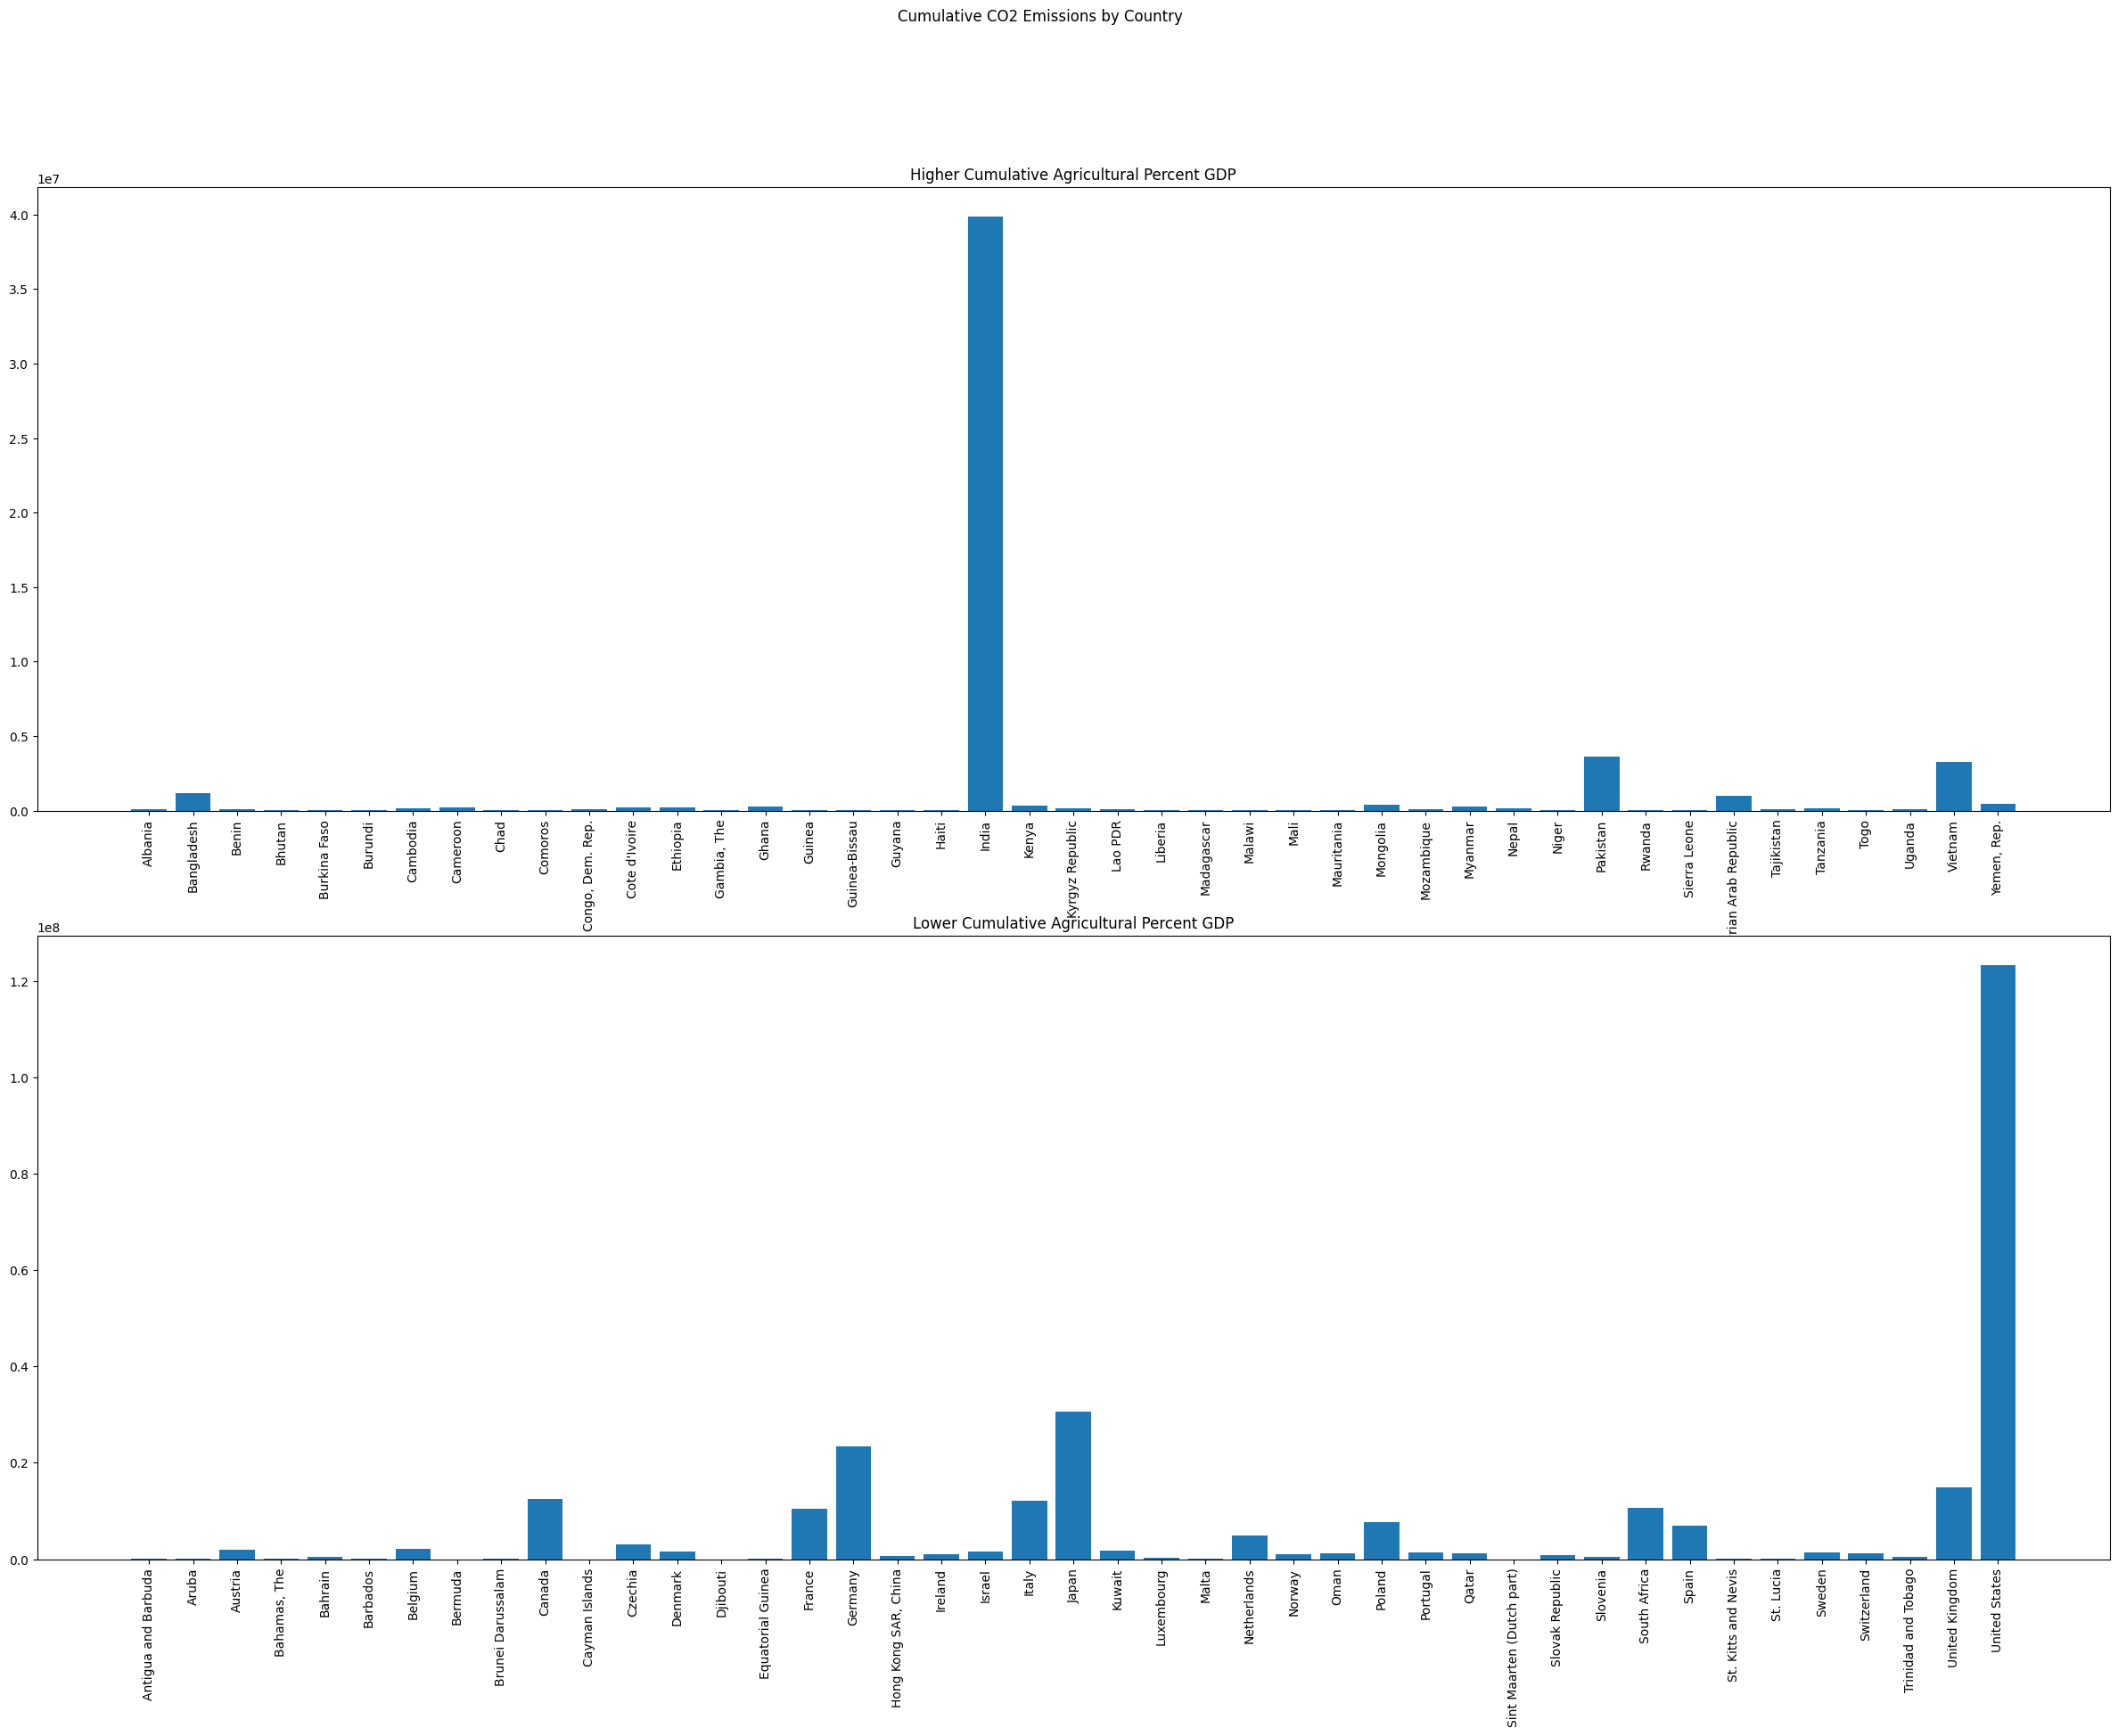

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,20))

fig.suptitle('Cumulative CO2 Emissions by Country')

ax1.bar(gdp_h.index,gdp_h['co2_emissions'])
ax1.set_title('Higher Cumulative Agricultural Percent GDP')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2.bar(gdp_l.index,gdp_l['co2_emissions'])
ax2.set_title('Lower Cumulative Agricultural Percent GDP')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

plt.show()

#### Population Size for GDP Groups

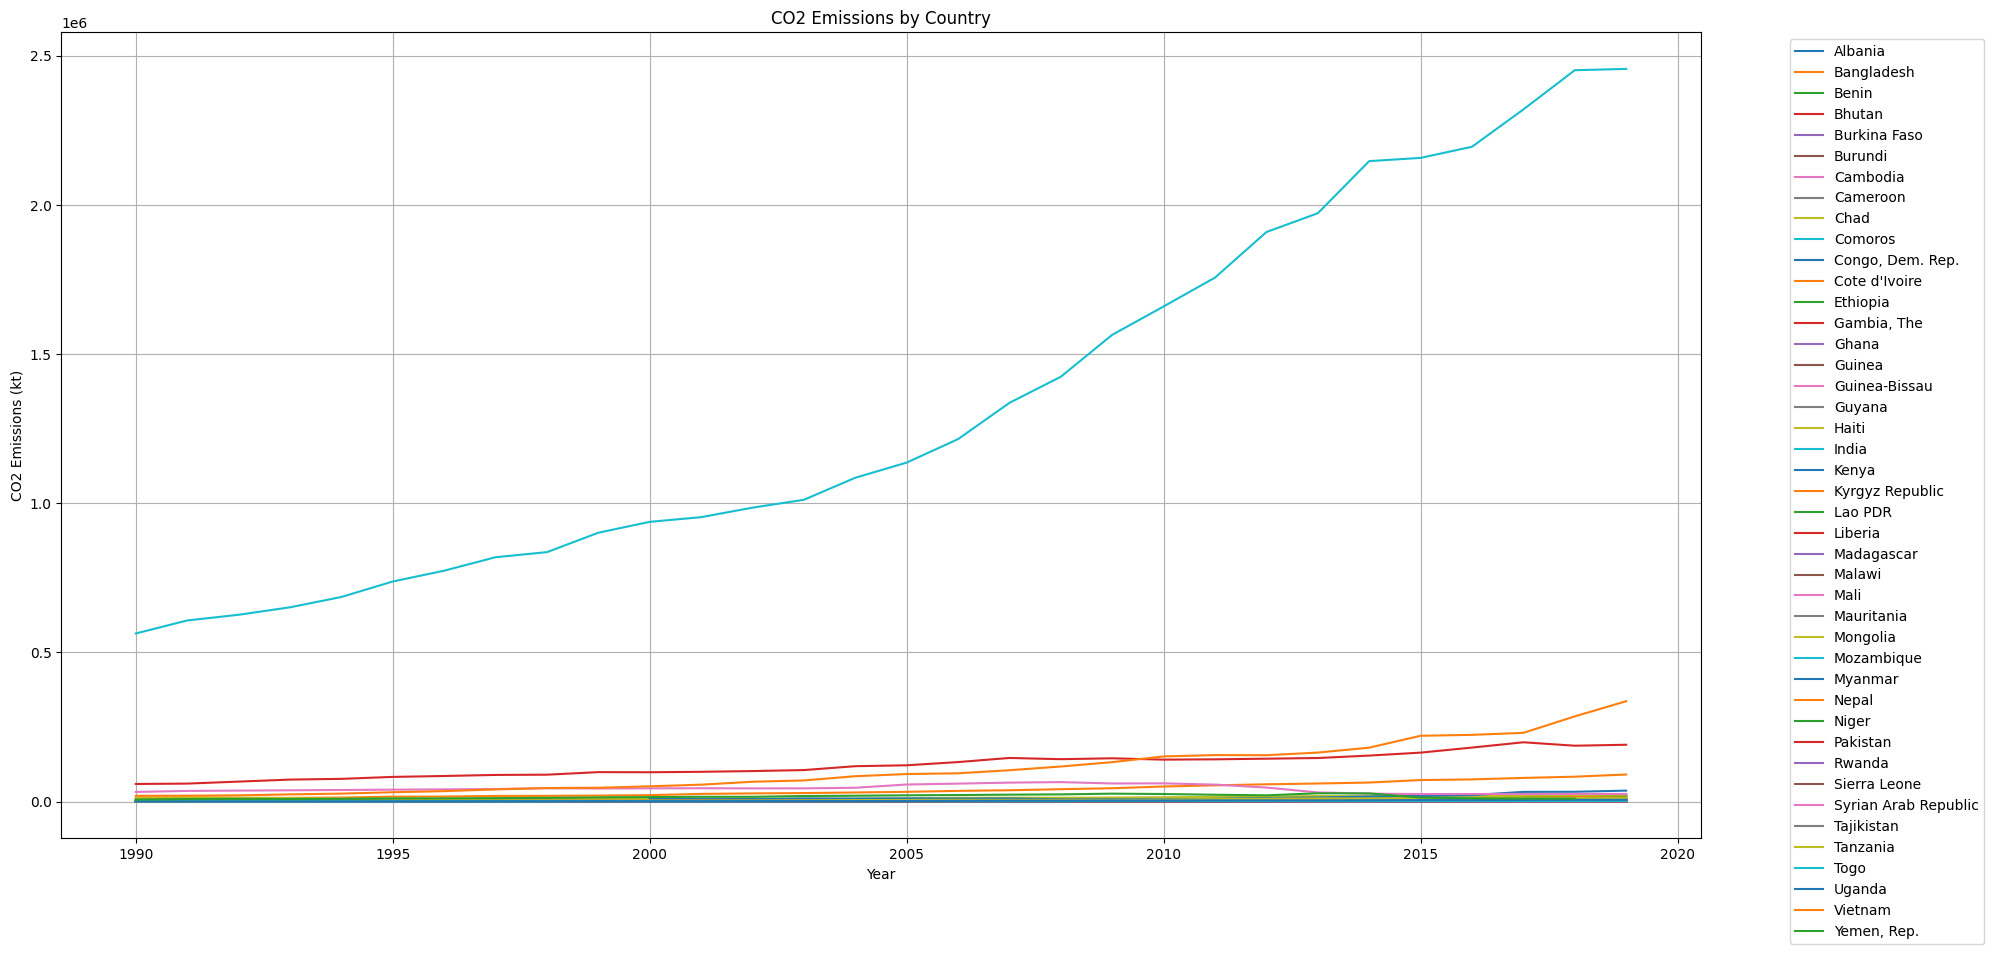

In [13]:
plt.figure(figsize=(20,10))

# Higher ag_percent_gdp country CO2 emissions
for country in gdp_h.index:
    data = df.loc[df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(gdp_h.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


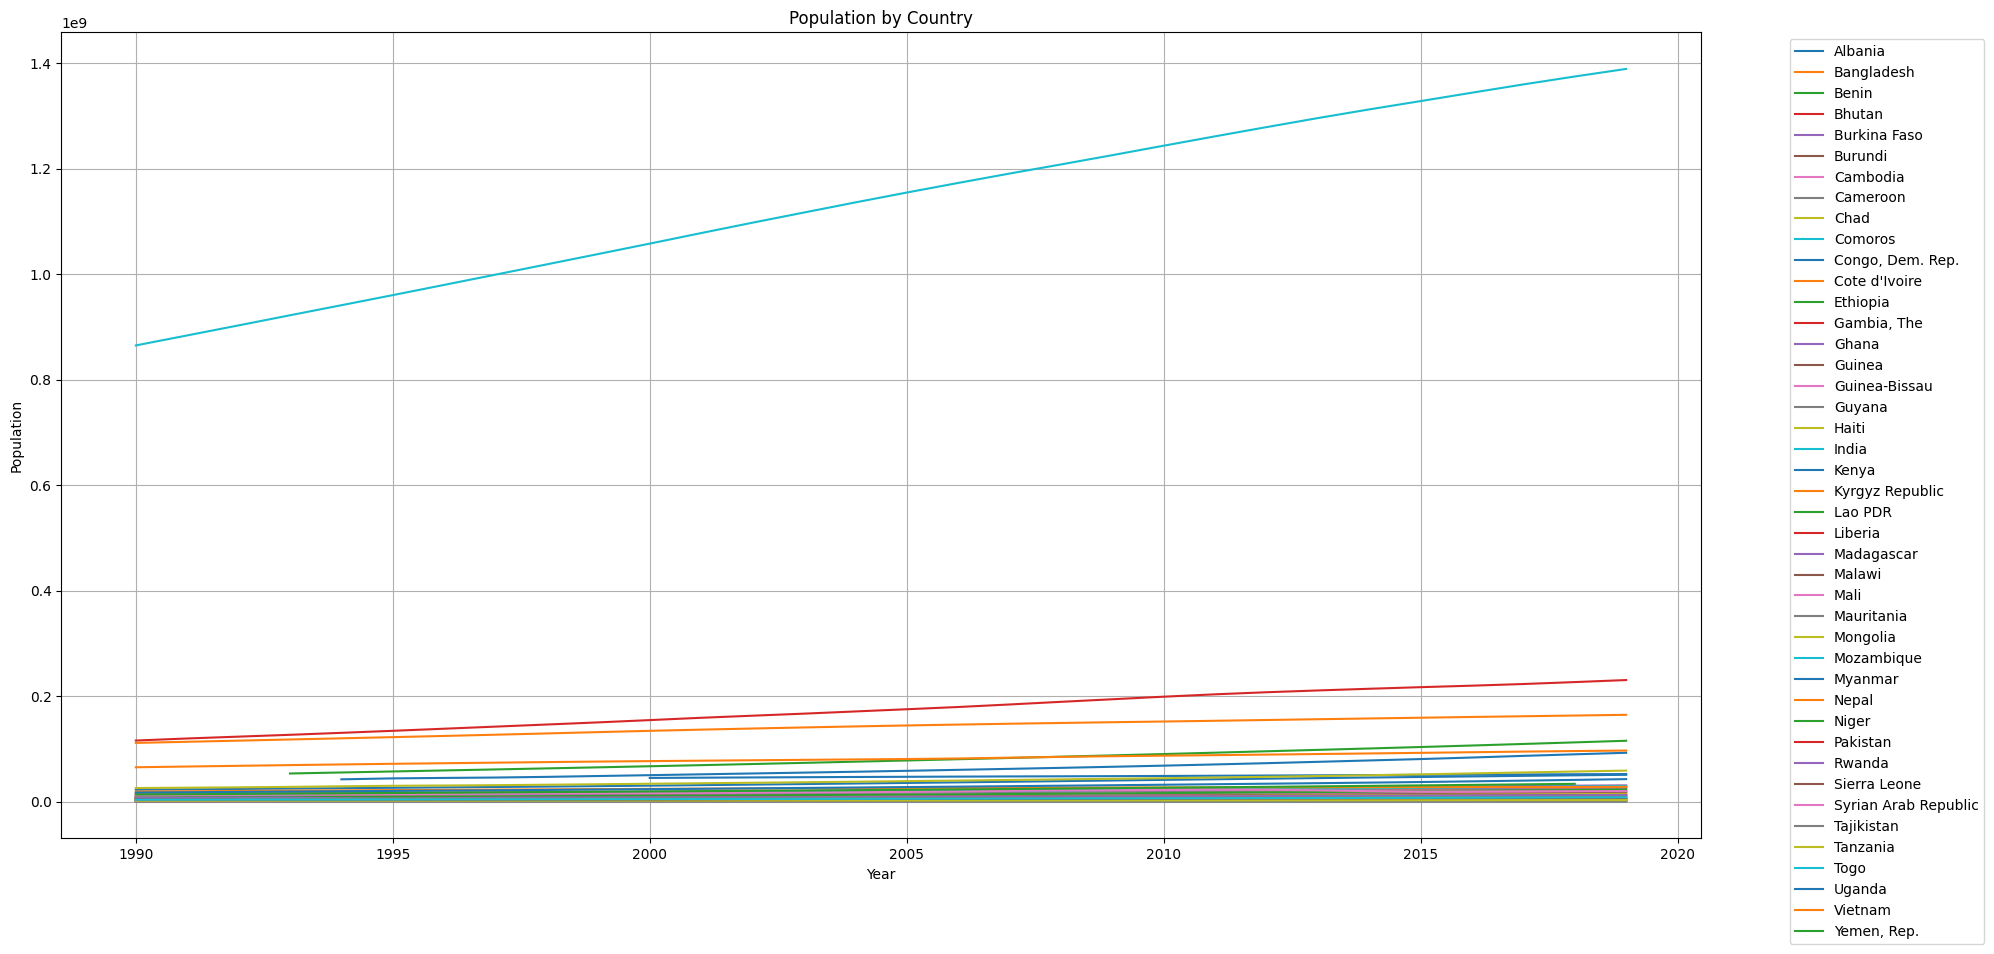

In [14]:
plt.figure(figsize=(20,10))

# Higher ag_percent_gdp country CO2 emissions
for country in gdp_h.index:
    data = df.loc[df['country'] == country]
    plt.plot(data['year'], data['population'])

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(gdp_h.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

##### Agricultural GDP

In [15]:
a_gdp_h = cumulative.loc[cumulative["ag_gdp"] >= c_summary["ag_gdp"]["75%"]]
a_gdp_l = cumulative.loc[cumulative["ag_gdp"] < c_summary["ag_gdp"]["25%"]]

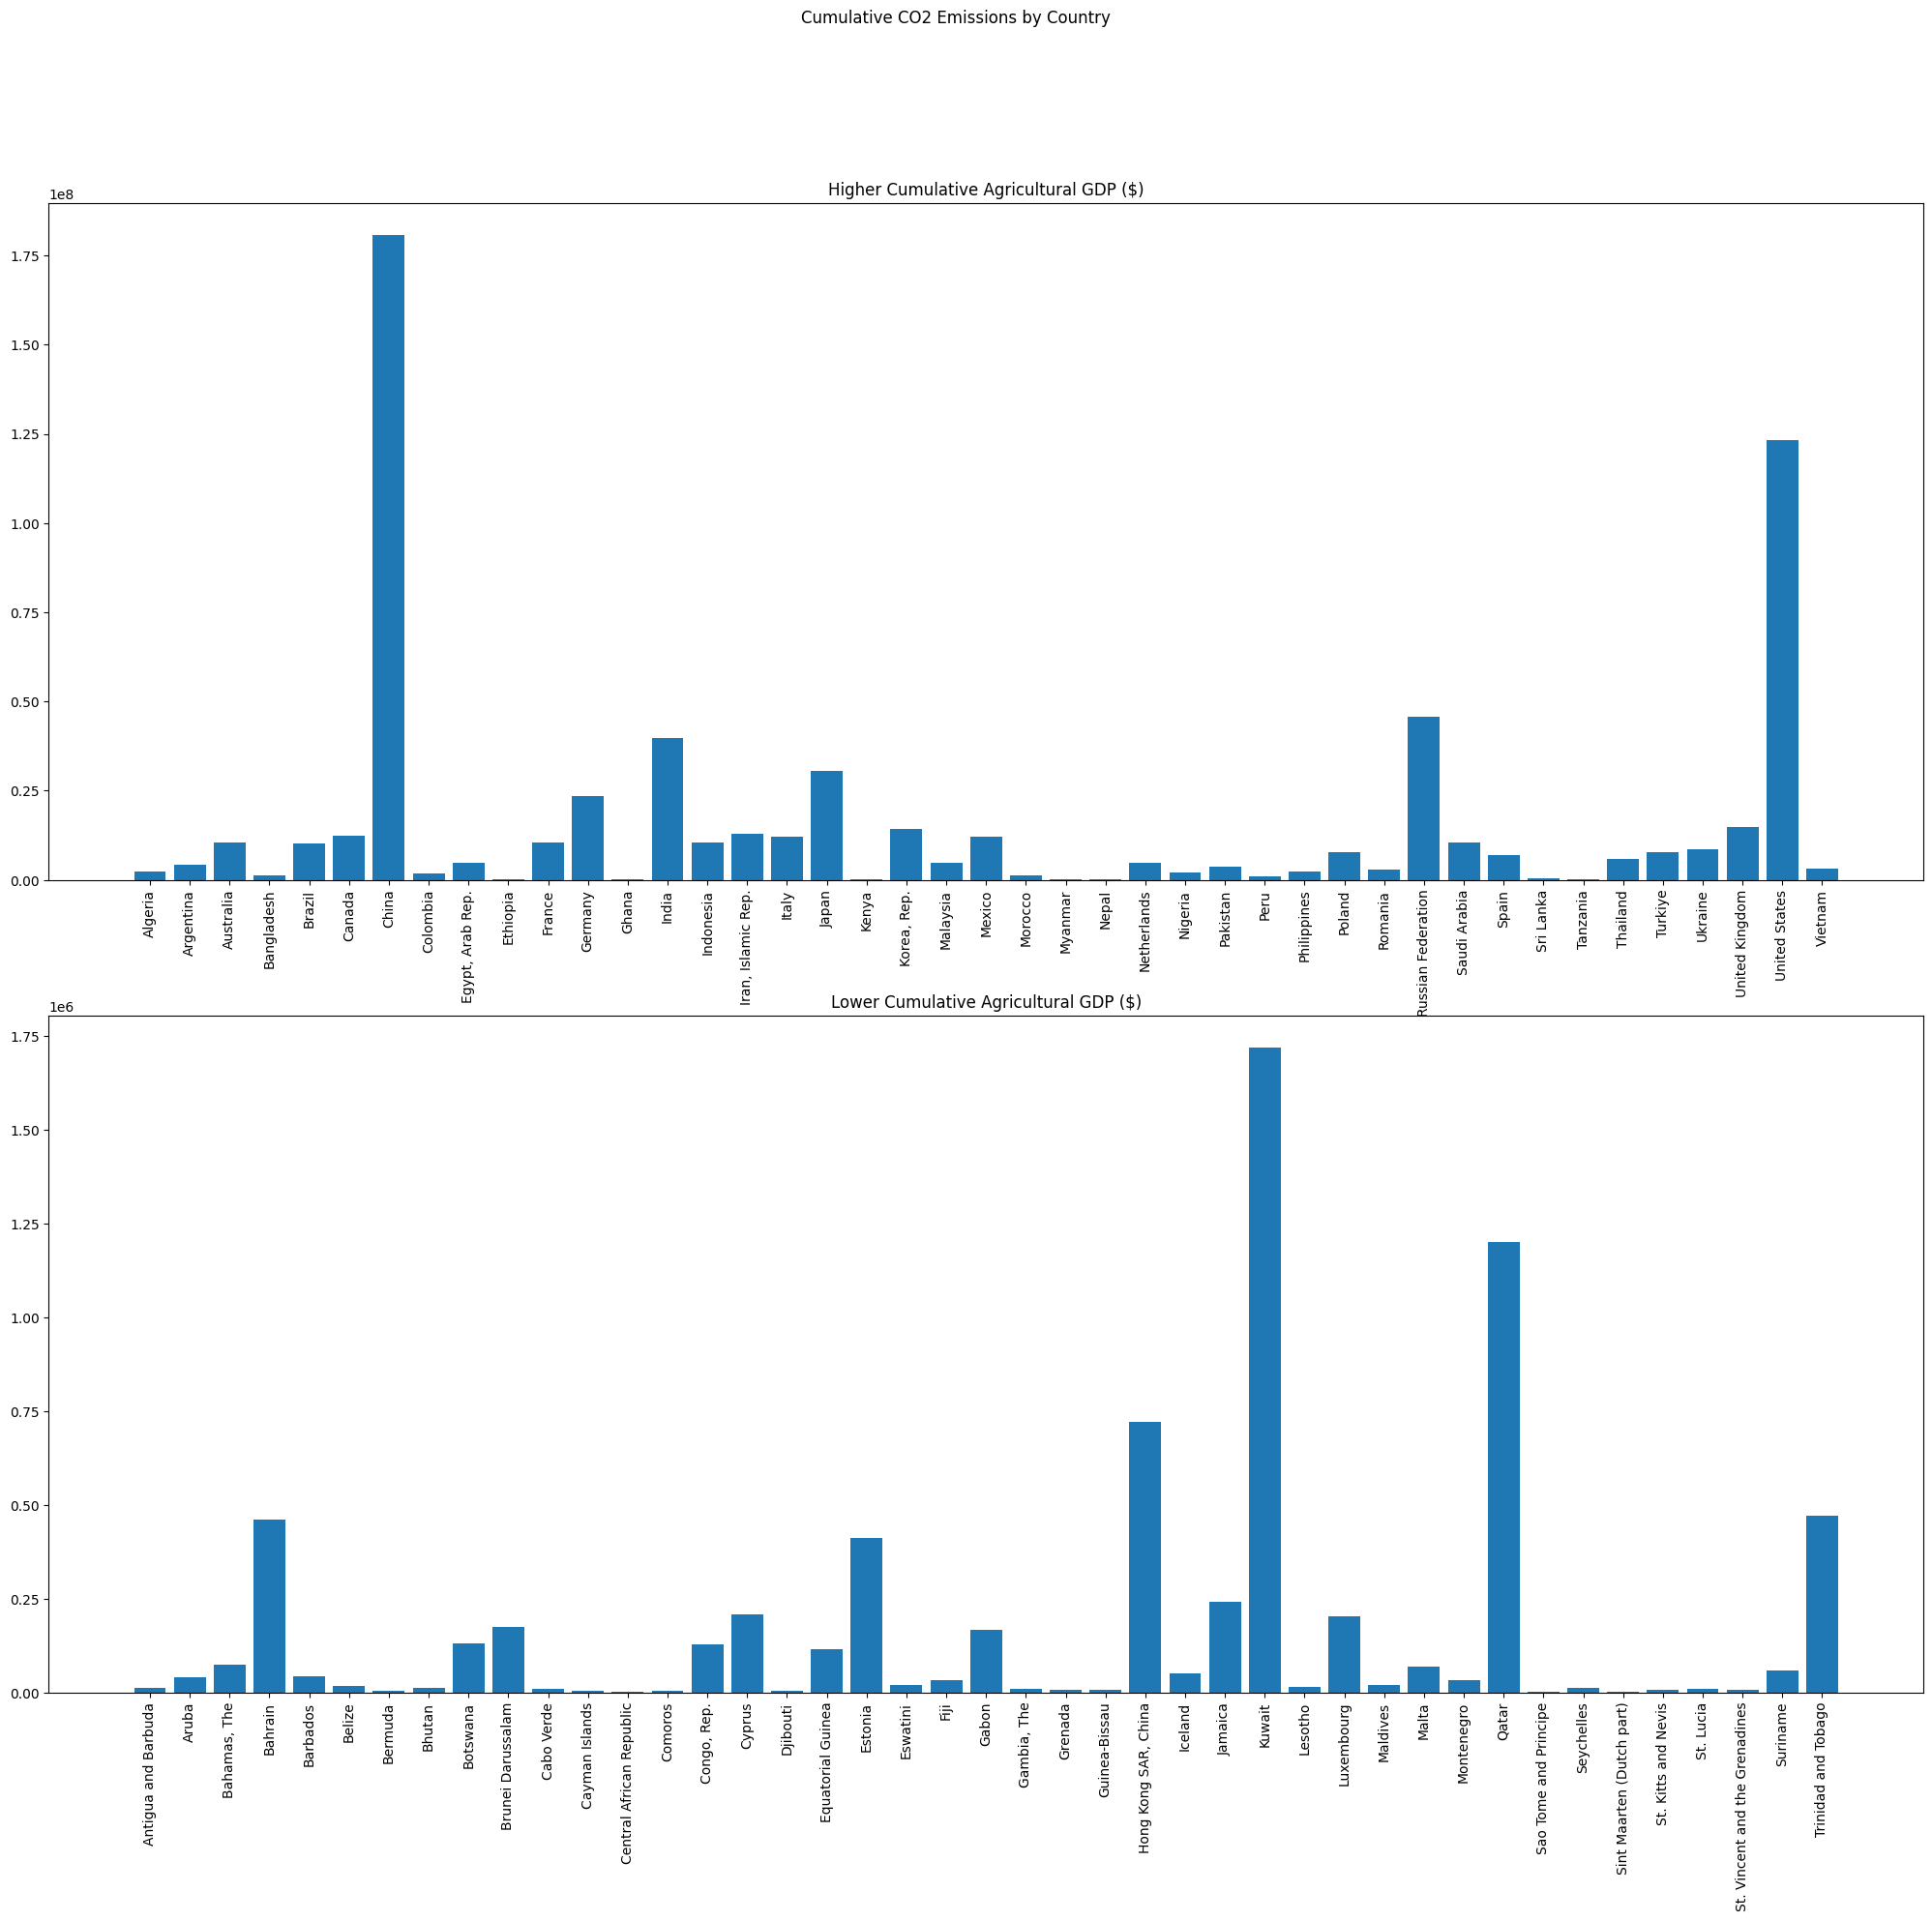

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,20))

fig.suptitle('Cumulative CO2 Emissions by Country')

ax1.bar(a_gdp_h.index,a_gdp_h['co2_emissions'])
ax1.set_title('Higher Cumulative Agricultural GDP ($)')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2.bar(a_gdp_l.index,a_gdp_l['co2_emissions'])
ax2.set_title('Lower Cumulative Agricultural GDP ($)')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

plt.show()

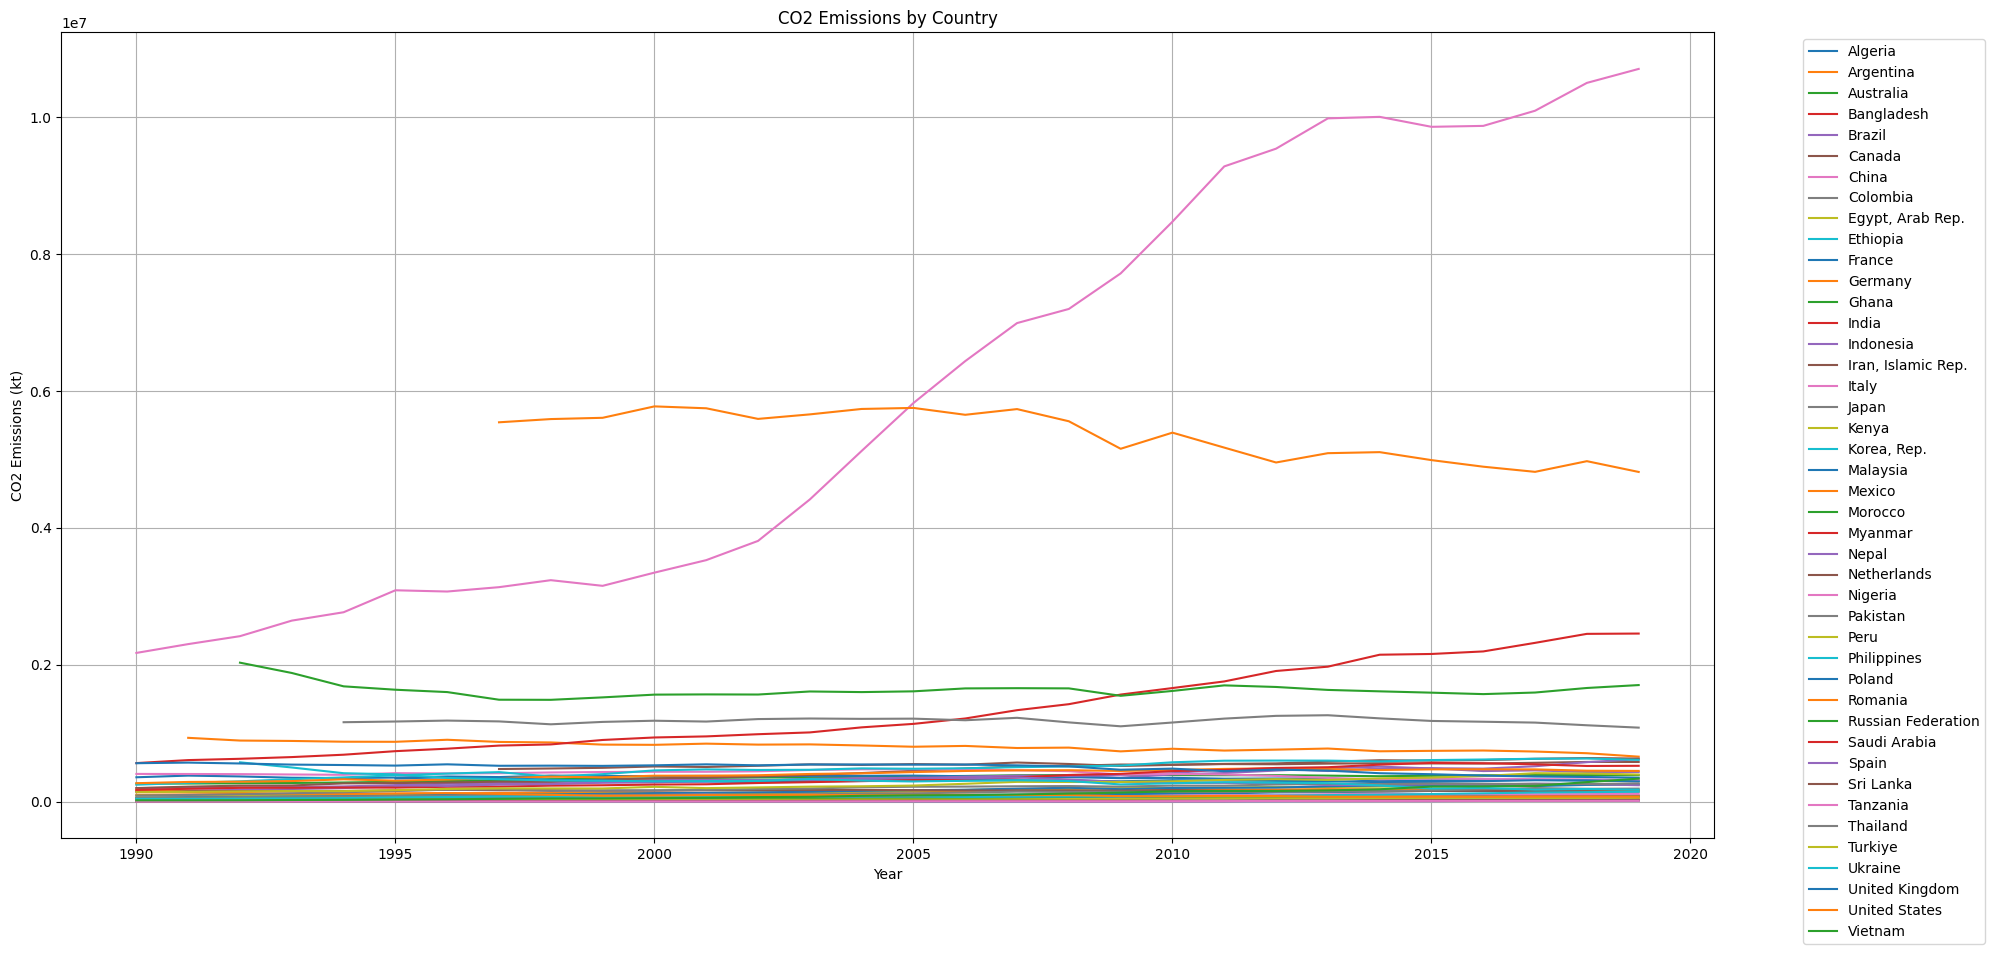

In [17]:
plt.figure(figsize=(20,10))

# higher ag_gdp ($) countries CO2 emissions YOY
for country in a_gdp_h.index:
    data = df.loc[df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(a_gdp_h.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


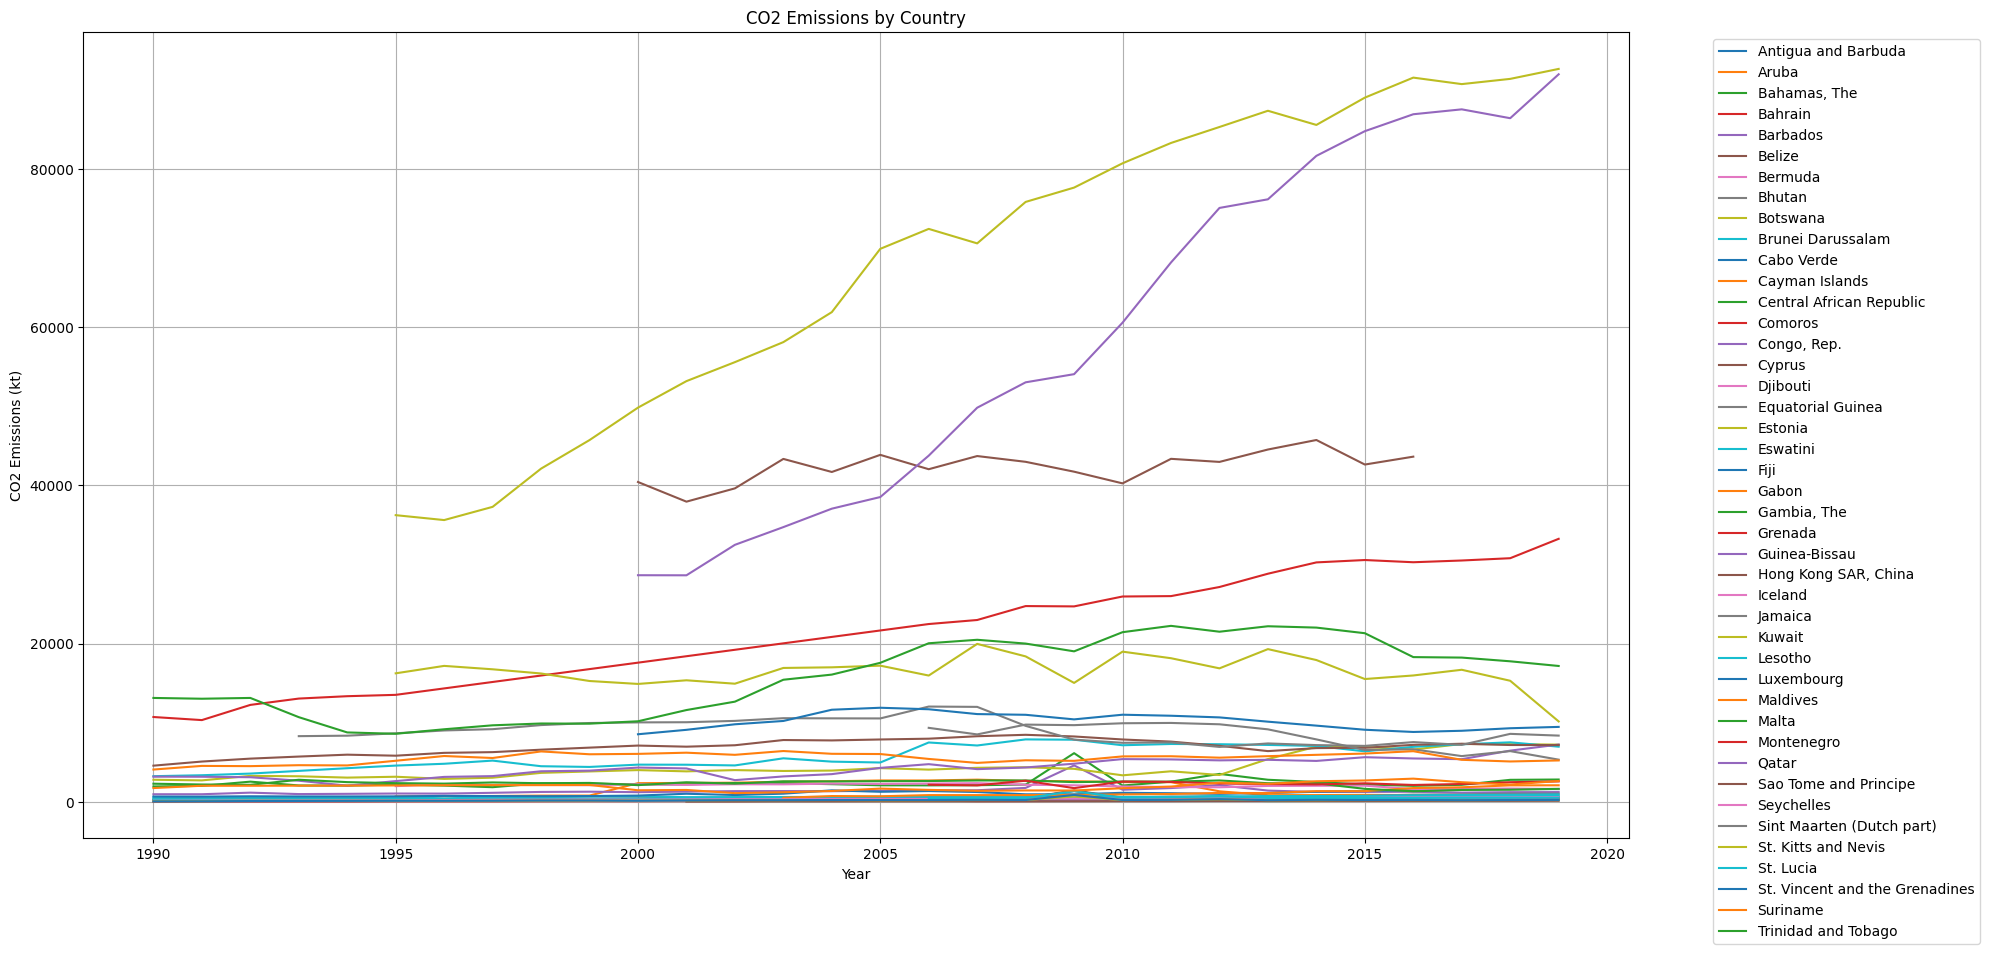

In [18]:
plt.figure(figsize=(20,10))

# lower ag_gdp ($) countries CO2 emissions YOY
for country in a_gdp_l.index:
    data = df.loc[df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(a_gdp_l.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

### Create Variable for Population to GDP

In [19]:
m_df = df
m_df["pop_to_gdp"] = (m_df["gdp"]/m_df["population"]).round(2)
m_df["pop_to_ag_gdp"] =  (m_df["ag_gdp"]/m_df["population"]).round(2)
m_df.sort_values(by="pop_to_ag_gdp",ascending=False)

country_code  country  year  co2_emissions  pesticide_by_tonnes  \
2215          ISL  Iceland  1998    2150.000000                 3.21   
2216          ISL  Iceland  1999    2120.000000                 3.21   
2218          ISL  Iceland  2001    2160.000000                 4.74   
2229          ISL  Iceland  2012    1860.000014                 3.14   
2219          ISL  Iceland  2002    2240.000010                 4.00   
...           ...      ...   ...            ...                  ...   
8             ABW    Aruba  2003    2563.233000               398.84   
7             ABW    Aruba  2002    2438.555000               377.95   
21            ABW    Aruba  2016     883.747000               459.14   
19            ABW    Aruba  2014     872.746000               390.52   
20            ABW    Aruba  2015     898.415000               454.47   

      ag_percent_gdp  population           gdp        ag_gdp  pop_to_gdp  \
2215        8.109185      274119  1.043545e+10  8.462296e+10    38069.04   
2216        7.600721      277450  1.117142e+10  8.491088e+10    40264.64   
2218        7.468341      285060  1.163828e+10  8.691866e+10    40827.48   
2229        6.548052      320847  1.482681e+10  9.708671e+10    46211.46   
2219        7.494012      287609  1.161016e+10  8.700664e+10    40367.84   
...              ...         ...           ...           ...         ...   
8           0.018011       92324  3.701984e+09  6.667488e+07    40097.74   
7           0.018054       91392  3.555261e+09  6.418645e+07    38901.23   
21          0.018612      104989  3.320977e+09  6.180925e+07    31631.67   
19          0.014813      103381  4.075201e+09  6.036585e+07    39419.25   
20          0.012520      104200  3.921183e+09  4.909238e+07    37631.32   

      pop_to_ag_gdp  
2215      308708.85  
2216      306040.31  
2218      304913.55  
2229      302595.04  
2219      302517.10  
...             ...  
8            722.18  
7            702.32  
21           588.72  
19           583.92  
20           471.14  

[4597 rows x 11 columns]

In [20]:
m_corr_matrix = df[["year","co2_emissions","pesticide_by_tonnes","population","ag_percent_gdp","gdp","ag_gdp","pop_to_gdp","pop_to_ag_gdp"]].corr().round(2)
m_corr_matrix

year  co2_emissions  pesticide_by_tonnes  population  \
year                 1.00           0.05                 0.07        0.02   
co2_emissions        0.05           1.00                 0.70        0.72   
pesticide_by_tonnes  0.07           0.70                 1.00        0.52   
population           0.02           0.72                 0.52        1.00   
ag_percent_gdp      -0.20          -0.11                -0.13        0.03   
gdp                  0.10           0.93                 0.77        0.64   
ag_gdp               0.06           0.76                 0.52        0.96   
pop_to_gdp           0.21           0.12                 0.11       -0.06   
pop_to_ag_gdp        0.08           0.03                 0.07        0.01   

                     ag_percent_gdp   gdp  ag_gdp  pop_to_gdp  pop_to_ag_gdp  
year                          -0.20  0.10    0.06        0.21           0.08  
co2_emissions                 -0.11  0.93    0.76        0.12           0.03  
pesticide_by_tonnes           -0.13  0.77    0.52        0.11           0.07  
population                     0.03  0.64    0.96       -0.06           0.01  
ag_percent_gdp                 1.00 -0.15    0.02       -0.57           0.03  
gdp                           -0.15  1.00    0.66        0.20           0.03  
ag_gdp                         0.02  0.66    1.00       -0.05           0.09  
pop_to_gdp                    -0.57  0.20   -0.05        1.00           0.05  
pop_to_ag_gdp                  0.03  0.03    0.09        0.05           1.00

##### Create New Groups Based on Summary Stats

In [21]:
m_cumulative = m_df[["country","co2_emissions","pesticide_by_tonnes","ag_percent_gdp","gdp","ag_gdp","pop_to_gdp","pop_to_ag_gdp"]].groupby('country').sum()
m_cumulative.head()

co2_emissions  pesticide_by_tonnes  ag_percent_gdp  \
country                                                                   
Albania               9.423000e+04             10063.18      511.745810   
Algeria               2.475930e+06             96528.61      201.713975   
Angola                5.124900e+05              1296.00      178.525136   
Antigua and Barbuda   1.144000e+04              9321.64       44.261775   
Argentina             4.374320e+06           3858613.95      189.197937   

                              gdp        ag_gdp  pop_to_gdp  pop_to_ag_gdp  
country                                                                     
Albania              6.001048e+11  1.220698e+13   200901.44     4064762.24  
Algeria              9.384938e+12  9.016616e+13   258697.85     2457184.76  
Angola               3.226321e+12  2.362492e+13   134710.33      966362.31  
Antigua and Barbuda  3.370876e+10  5.485064e+10   428674.07      700308.35  
Argentina            1.889823e+13  1.165785e+14   472148.66     2917231.73

In [22]:
m_summary = m_cumulative.describe().loc[['min', '25%', '50%', '75%', 'max']]
m_summary

co2_emissions  pesticide_by_tonnes  ag_percent_gdp           gdp  \
min   7.150650e+02         2.942000e+01        0.076461  1.200541e+09   
25%   5.943000e+04         8.081717e+03       82.206934  4.776162e+11   
50%   2.999000e+05         3.920812e+04      224.208305  1.473261e+12   
75%   1.679505e+06         2.116855e+05      511.717472  7.399764e+12   
max   1.807228e+08         9.557800e+06     1516.441087  3.787195e+14   

           ag_gdp    pop_to_gdp  pop_to_ag_gdp  
min  9.179452e+07  1.044402e+04       2559.230  
25%  3.212785e+12  9.760009e+04    1158332.375  
50%  1.347481e+13  2.529032e+05    1809872.980  
75%  4.545692e+13  5.456795e+05    2462555.110  
max  3.202645e+15  2.497576e+06    6417403.910

In [23]:
m_gdp_h = m_cumulative.loc[m_cumulative["pop_to_gdp"] >= m_summary["pop_to_gdp"]["75%"]]
m_gdp_l = m_cumulative.loc[m_cumulative["pop_to_gdp"] < m_summary["pop_to_gdp"]["25%"]]

In [24]:
m_gdp_h.head()

co2_emissions  pesticide_by_tonnes  ag_percent_gdp  \
country                                                            
Aruba          3.964394e+04              8881.95        2.519467   
Australia      1.042195e+07           1145299.38       84.983947   
Austria        1.972000e+06            111784.10       48.923959   
Bahamas, The   7.332000e+04              9487.74       43.153917   
Bahrain        4.620700e+05               245.71        9.426406   

                       gdp        ag_gdp  pop_to_gdp  pop_to_ag_gdp  
country                                                              
Aruba         9.344039e+10  1.093891e+10  1006441.87      132658.29  
Australia     2.715068e+13  7.342168e+13  1283388.91     3531650.43  
Austria       1.017456e+13  1.545647e+13  1226439.99     1882080.01  
Bahamas, The  3.178611e+11  4.177320e+11   923973.27     1268212.41  
Bahrain       9.480572e+11  3.091453e+11   794808.73      288639.31

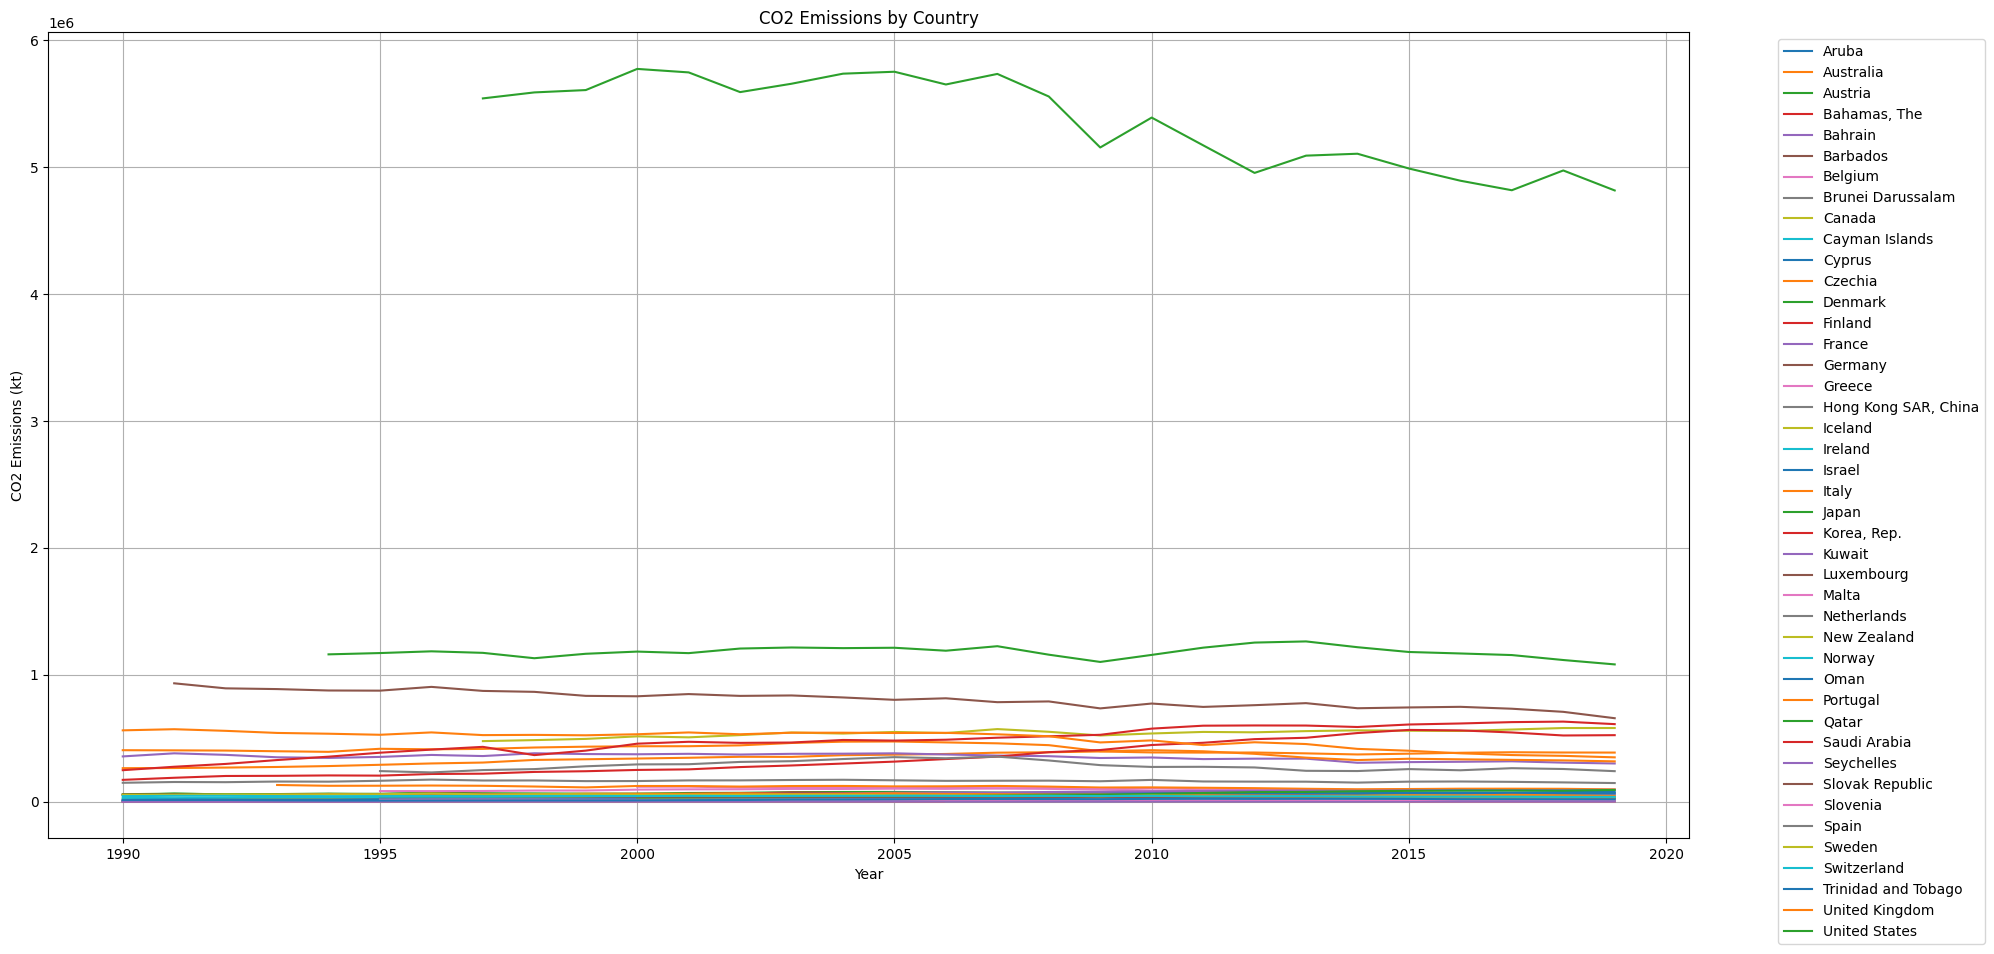

In [25]:
plt.figure(figsize=(20,10))

# higher ag_gdp ($) countries CO2 emissions YOY
for country in m_gdp_h.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_h.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

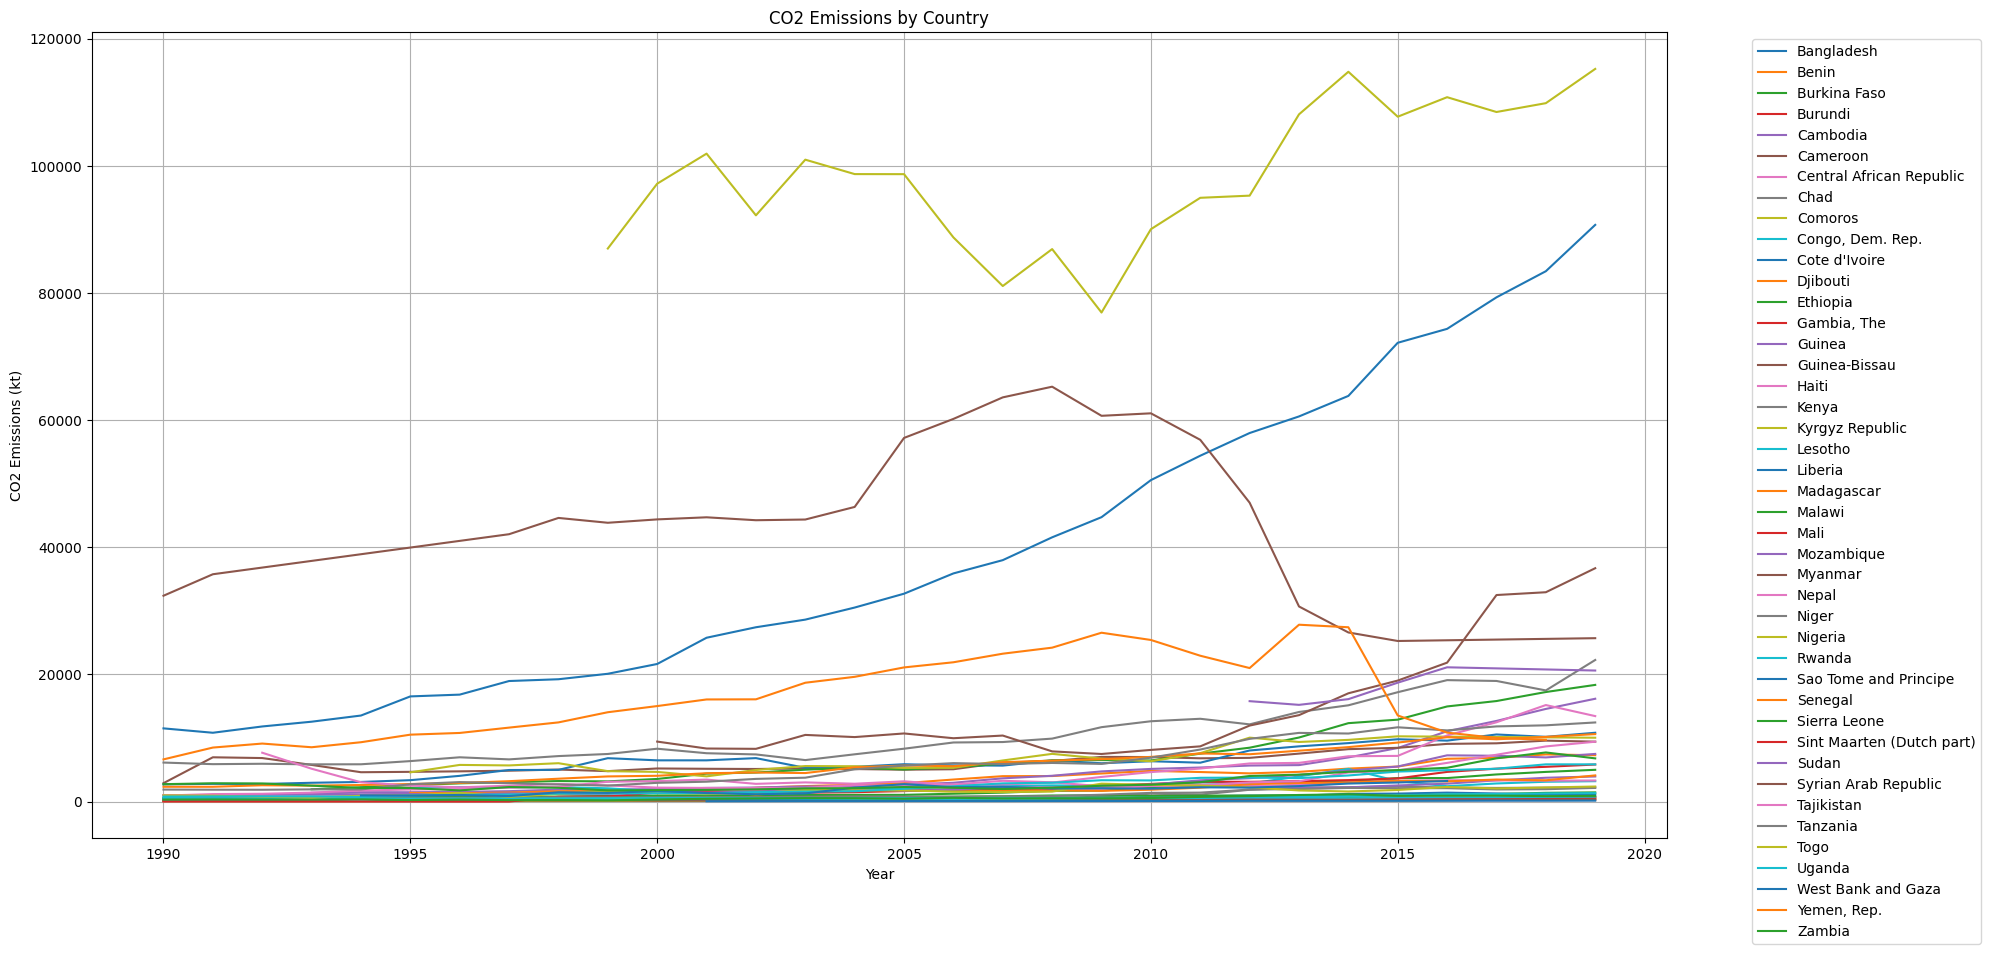

In [26]:
plt.figure(figsize=(20,10))

# lower ag_gdp ($) countries CO2 emissions YOY
for country in m_gdp_l.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_l.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

### Groups Created By Cumulative CO2 Emissions

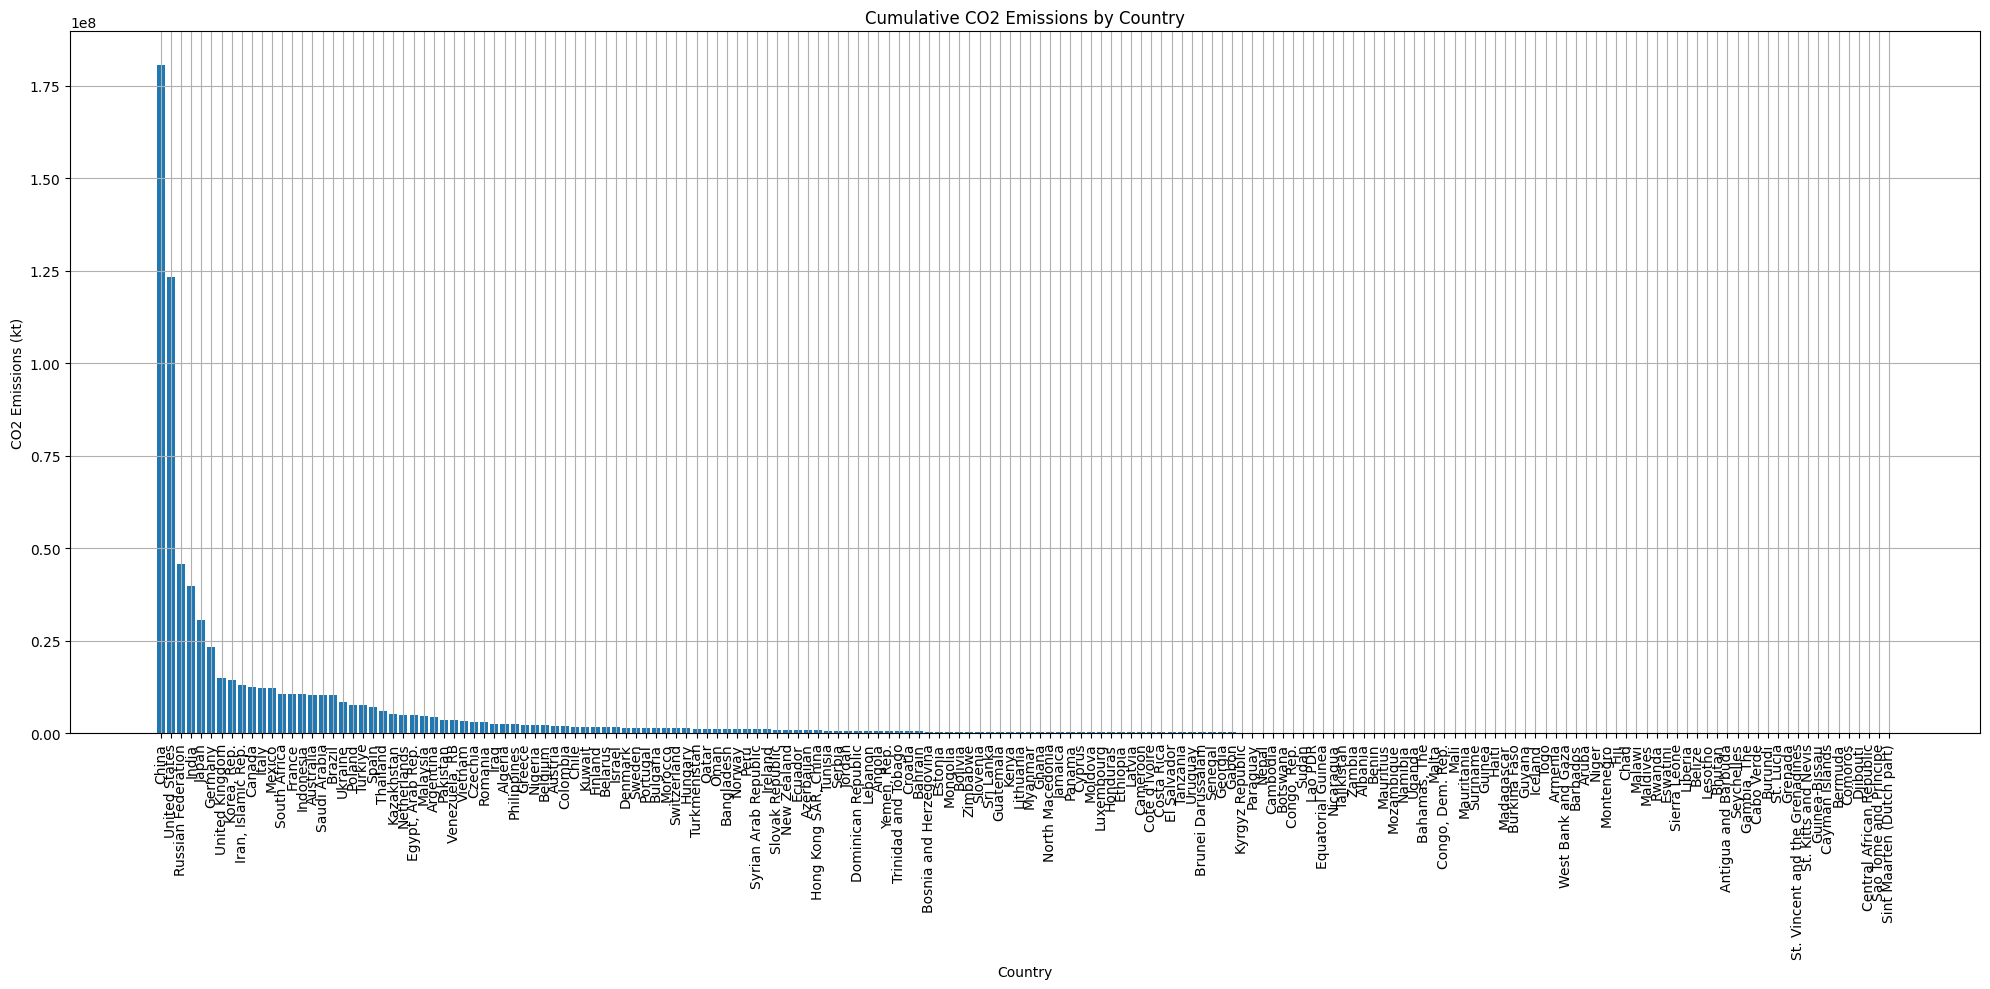

In [27]:
sorted_df = m_cumulative.sort_values(by="co2_emissions",ascending=False)

plt.figure(figsize=(20,10))

plt.bar(sorted_df.index, sorted_df["co2_emissions"])
plt.xticks(rotation=90)

plt.xlabel('Country')
plt.ylabel('CO2 Emissions (kt)')
plt.title('Cumulative CO2 Emissions by Country')
plt.grid(True)

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


#### Create a group of the highest and lowest quartiles based on cumulative CO2 emissions

In [28]:
m_gdp_high = m_cumulative.loc[m_cumulative["co2_emissions"] >= m_summary["co2_emissions"]["75%"]]
m_gdp_low = m_cumulative.loc[m_cumulative["co2_emissions"] < m_summary["co2_emissions"]["25%"]]

##### High Cummulative CO2 Emission Countries

In [29]:
print(m_gdp_high.index)

Index(['Algeria', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil',
       'Canada', 'Chile', 'China', 'Colombia', 'Czechia', 'Egypt, Arab Rep.',
       'France', 'Germany', 'Greece', 'India', 'Indonesia',
       'Iran, Islamic Rep.', 'Iraq', 'Italy', 'Japan', 'Kazakhstan',
       'Korea, Rep.', 'Kuwait', 'Malaysia', 'Mexico', 'Netherlands', 'Nigeria',
       'Pakistan', 'Philippines', 'Poland', 'Romania', 'Russian Federation',
       'Saudi Arabia', 'South Africa', 'Spain', 'Thailand', 'Turkiye',
       'Ukraine', 'United Kingdom', 'United States', 'Venezuela, RB',
       'Vietnam'],
      dtype='object', name='country')


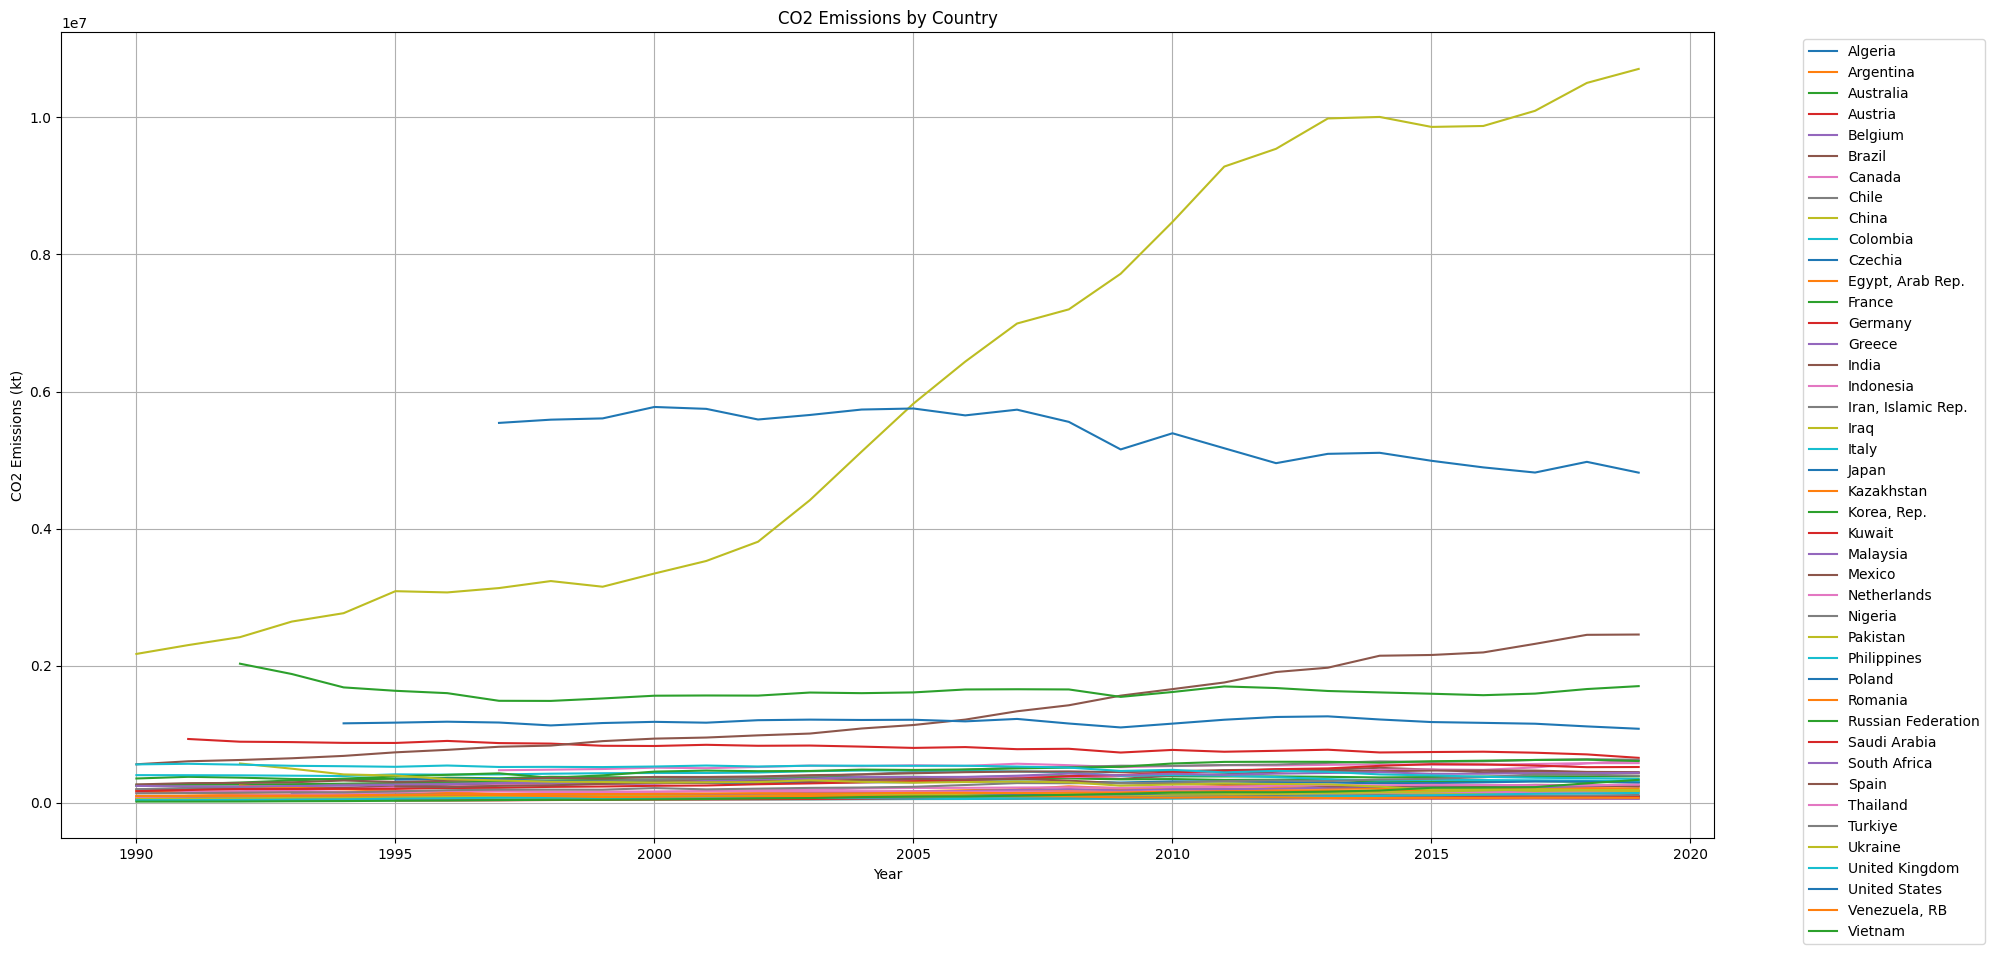

In [60]:
plt.figure(figsize=(20,10))

# higher cumulative co2 emission countries
for country in m_gdp_high.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_high.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.savefig("Images/HighCumulativeCO2-Line-Graph-CO2-Emissions.png")
plt.show()

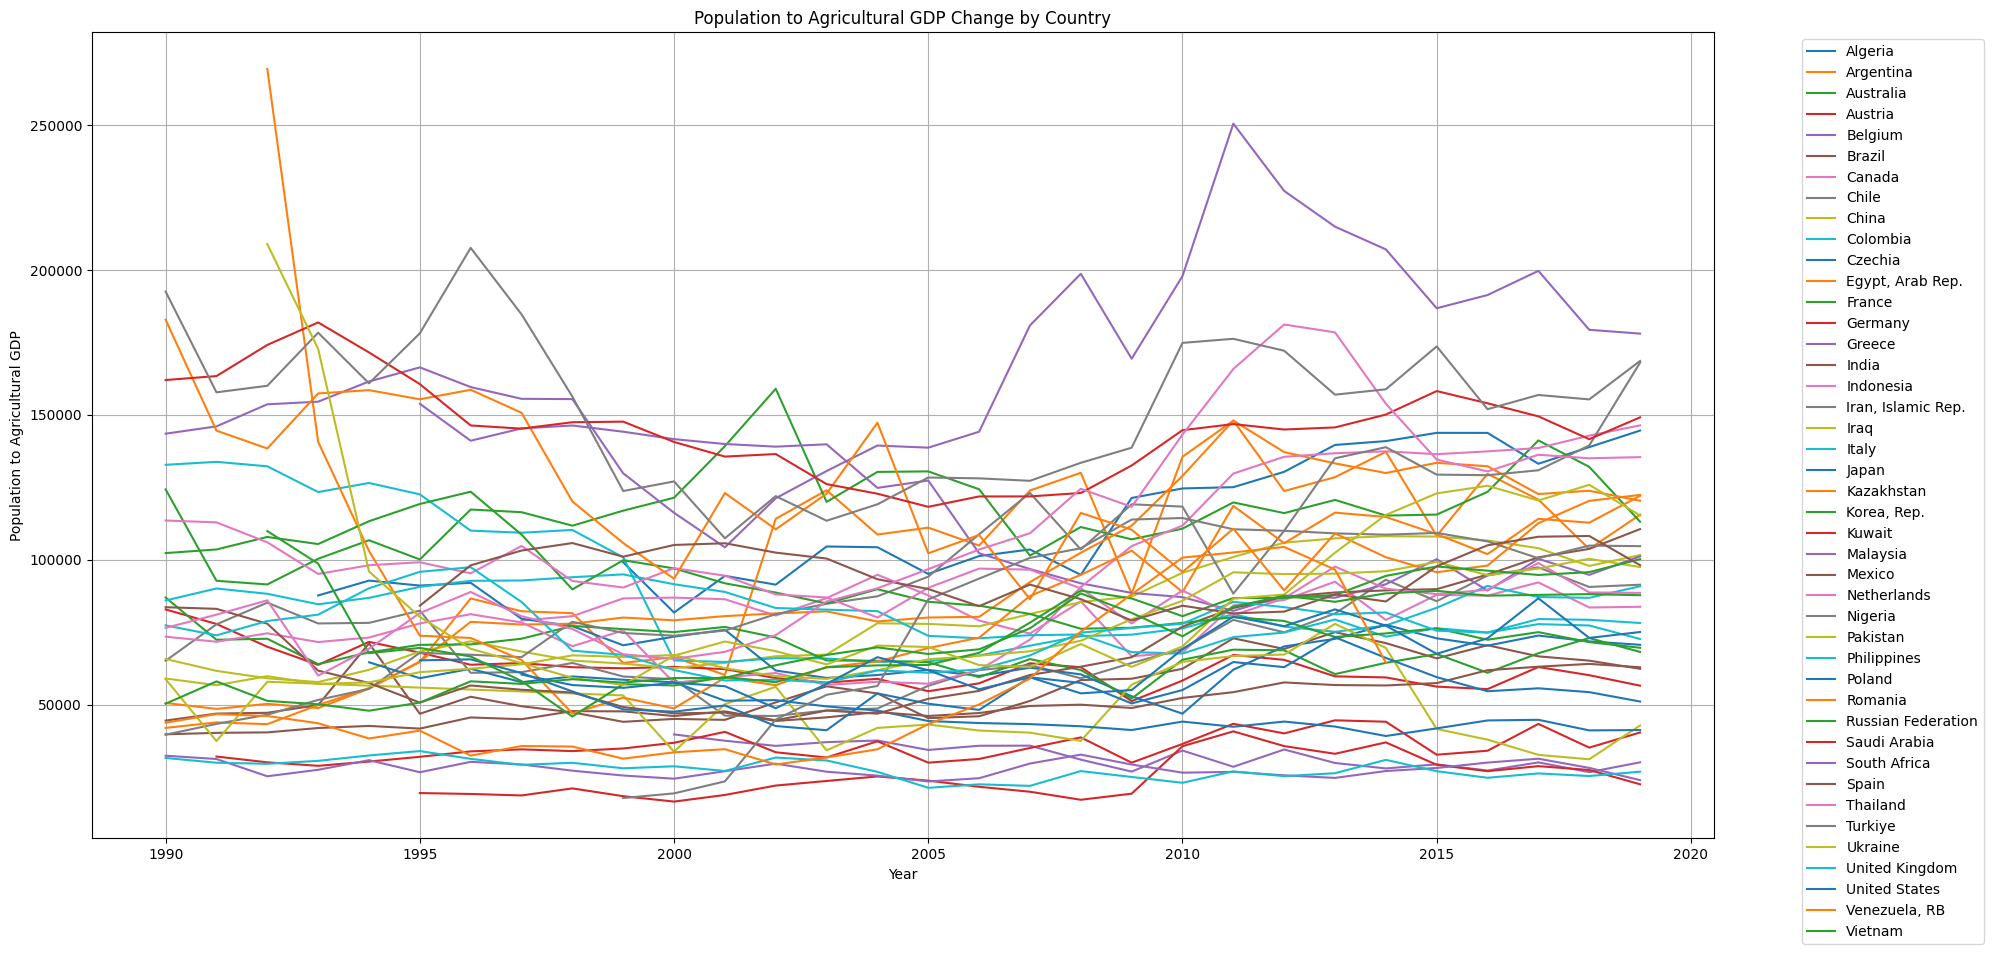

In [31]:
plt.figure(figsize=(20,10))

# higher cumulative co2 emission countries
for country in m_gdp_high.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['pop_to_ag_gdp'])

plt.xlabel('Year')
plt.ylabel('Population to Agricultural GDP')
plt.title('Population to Agricultural GDP Change by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_high.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

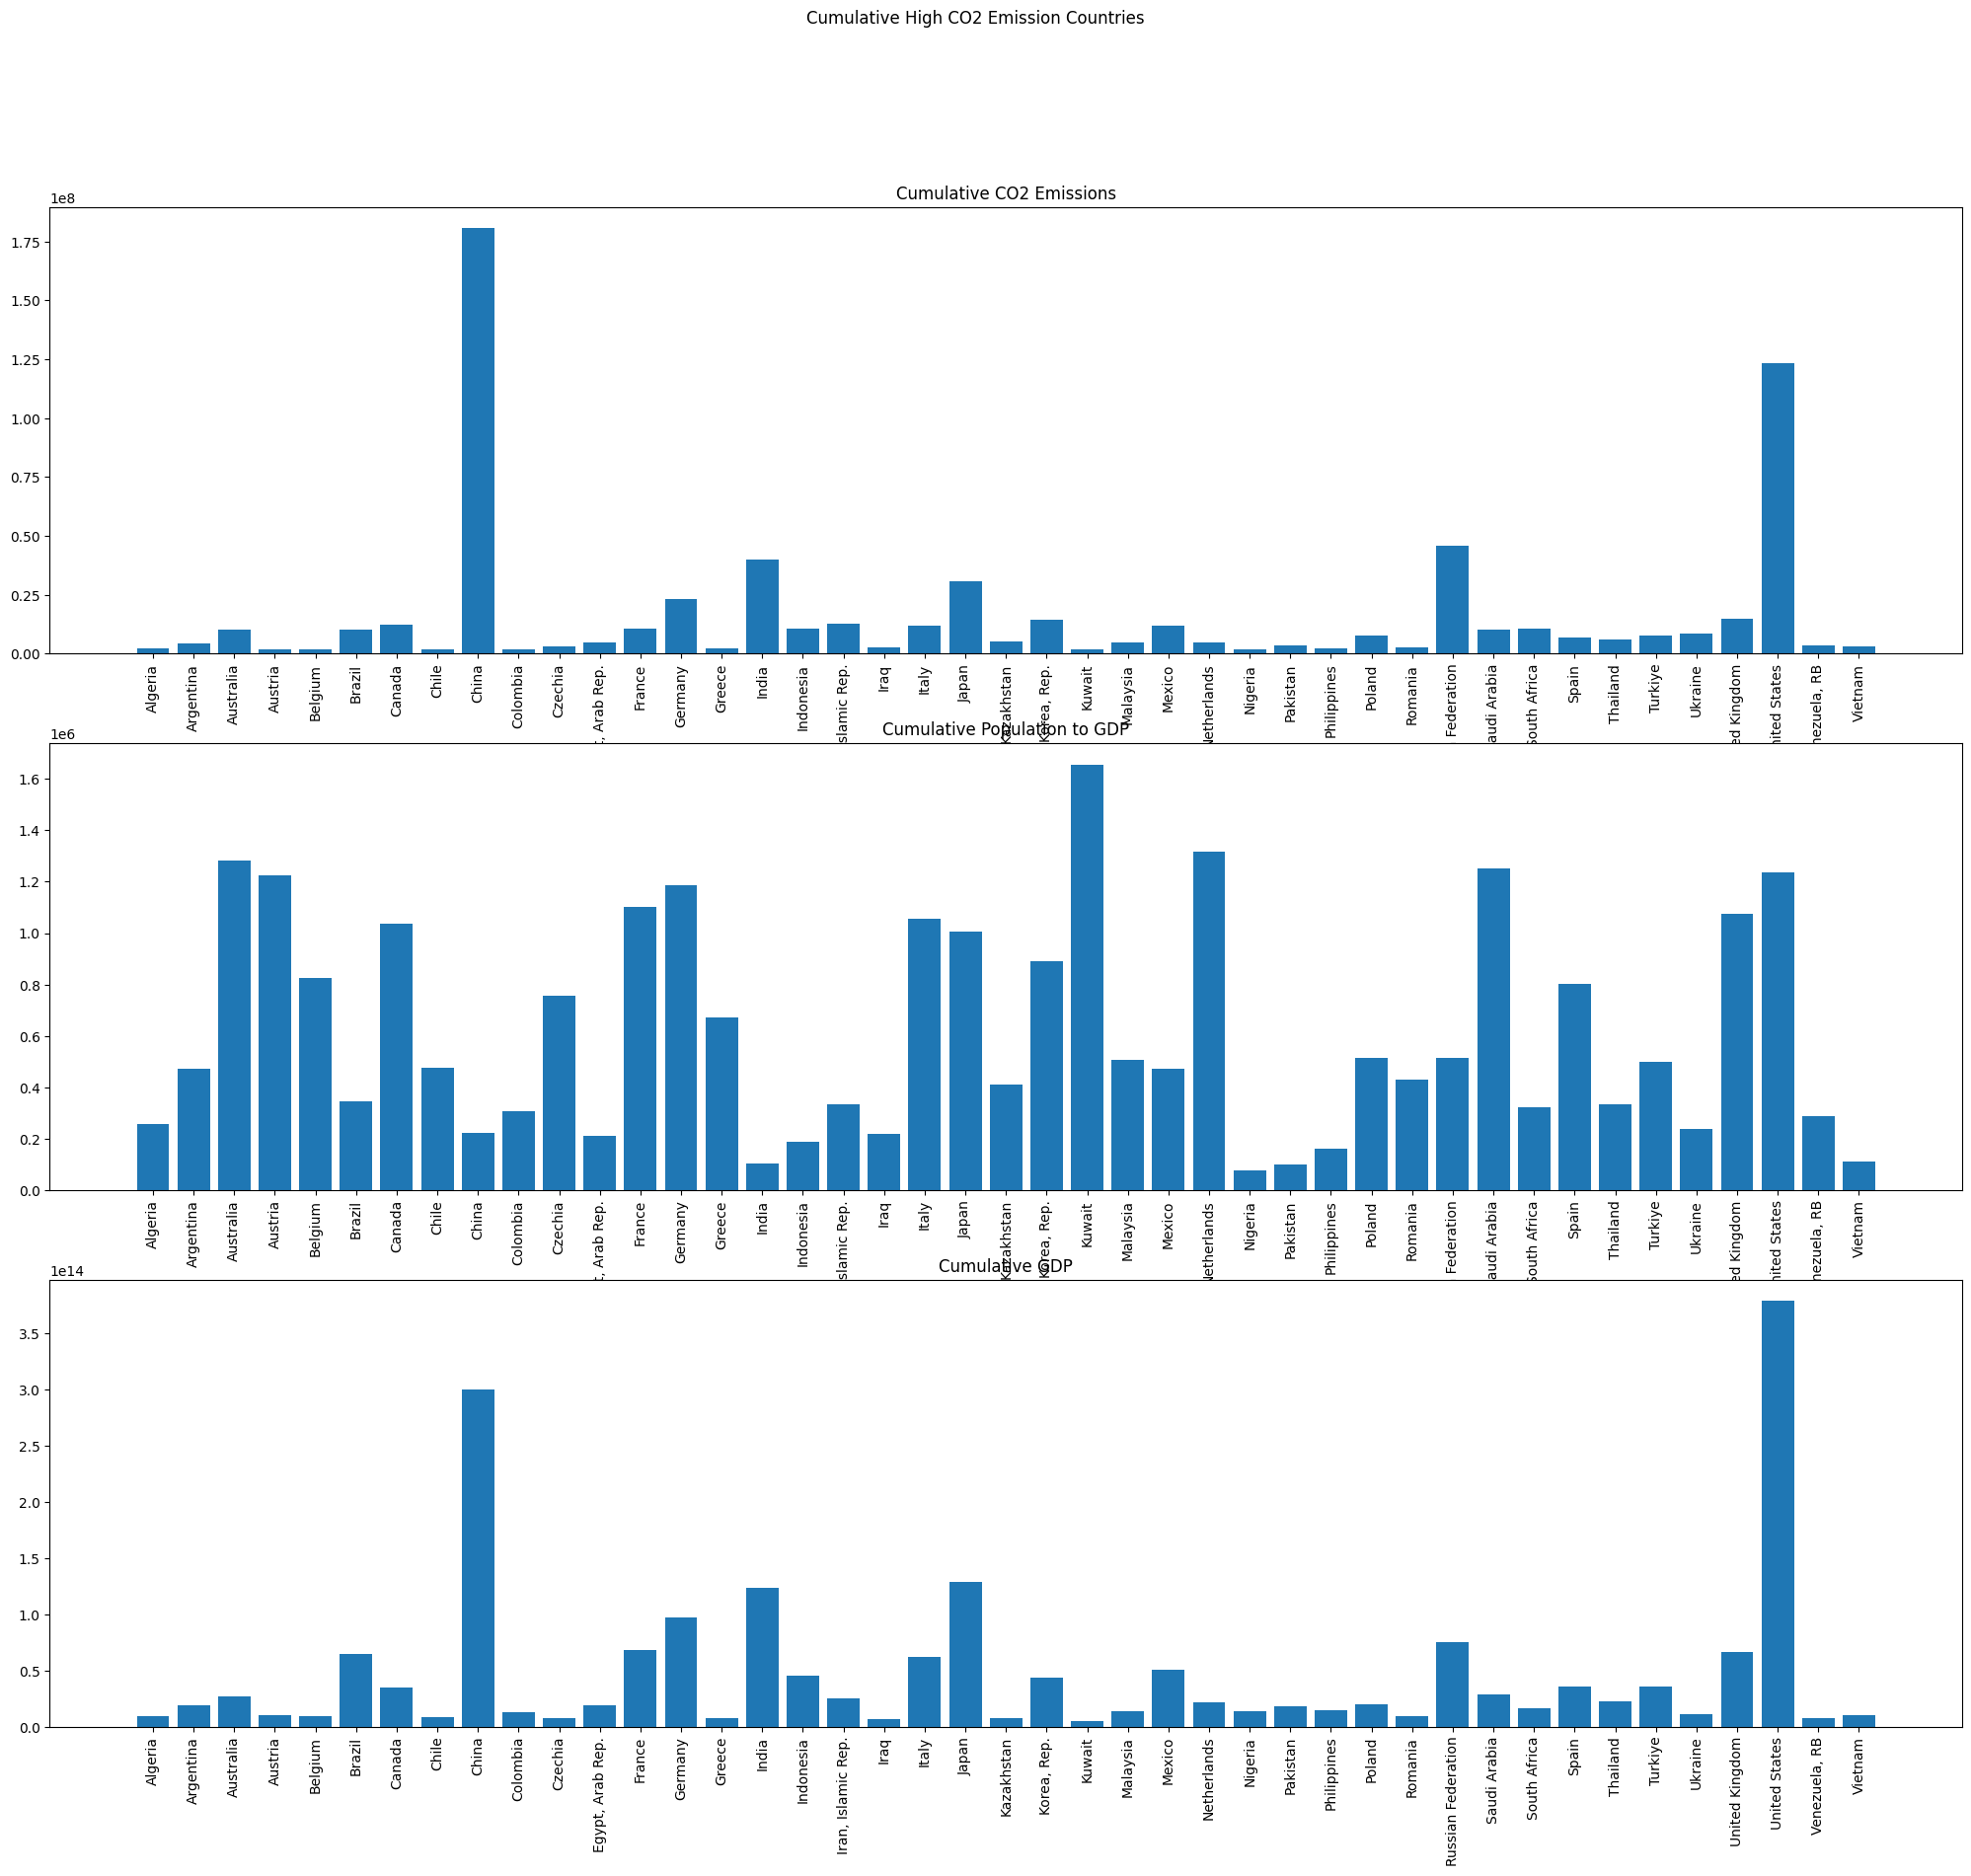

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,20))

fig.suptitle('Cumulative High CO2 Emission Countries')

ax1.bar(m_gdp_high.index,m_gdp_high['co2_emissions'])
ax1.set_title('Cumulative CO2 Emissions')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2.bar(m_gdp_high.index,m_gdp_high['pop_to_gdp'])
ax2.set_title('Cumulative Population to GDP')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

ax3.bar(m_gdp_high.index,m_gdp_high['gdp'])
ax3.set_title('Cumulative GDP')
ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)

plt.show()

##### Low Cumulative CO2 Emissions

In [33]:
print(m_gdp_low.index)

Index(['Antigua and Barbuda', 'Armenia', 'Aruba', 'Barbados', 'Belize',
       'Bermuda', 'Bhutan', 'Burkina Faso', 'Burundi', 'Cabo Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Comoros',
       'Djibouti', 'Eswatini', 'Fiji', 'Gambia, The', 'Grenada', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Iceland', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Maldives', 'Mauritania', 'Montenegro', 'Niger',
       'Rwanda', 'Sao Tome and Principe', 'Seychelles', 'Sierra Leone',
       'Sint Maarten (Dutch part)', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Suriname', 'Togo',
       'West Bank and Gaza'],
      dtype='object', name='country')


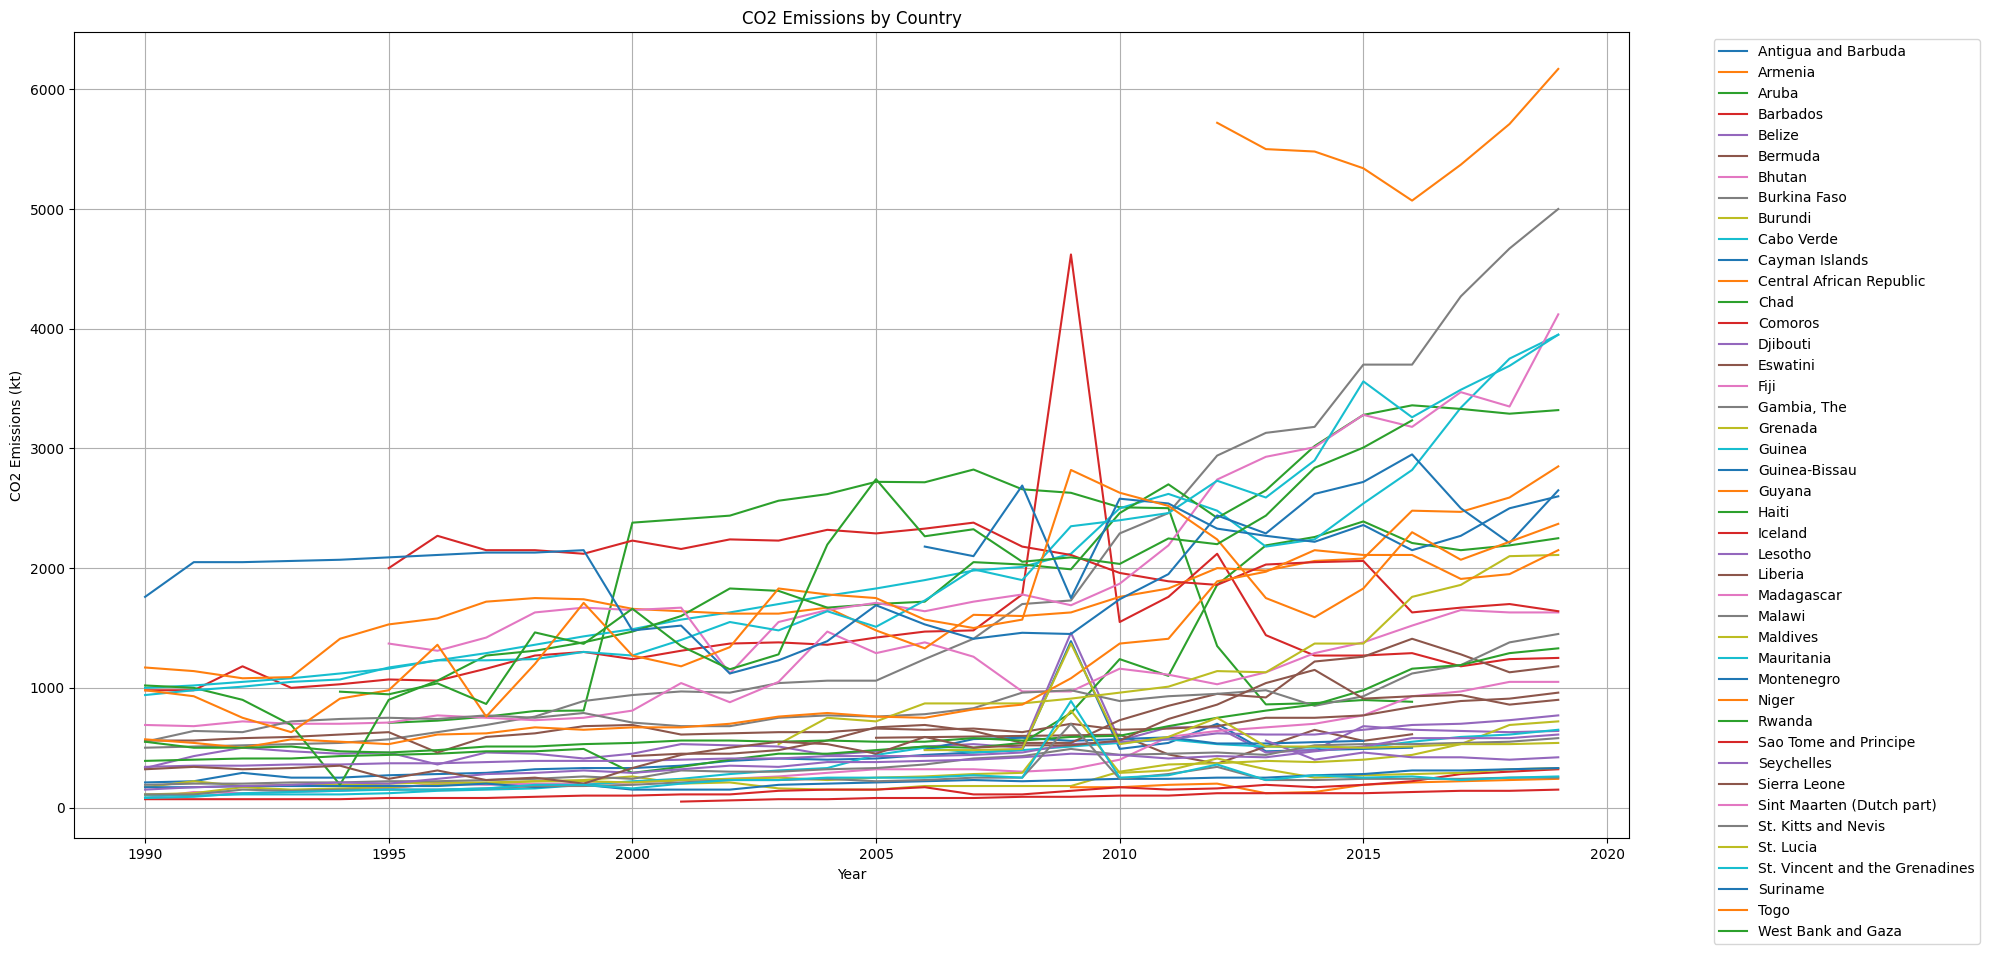

In [61]:
plt.figure(figsize=(20,10))

# lower cumulative co2 emission countries
for country in m_gdp_low.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['co2_emissions'])

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.title('CO2 Emissions by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_low.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Save and show the plot
plt.savefig('Images/LowCumulativeCO2-Line-Graph-CO2-Emissions.png')
plt.show()

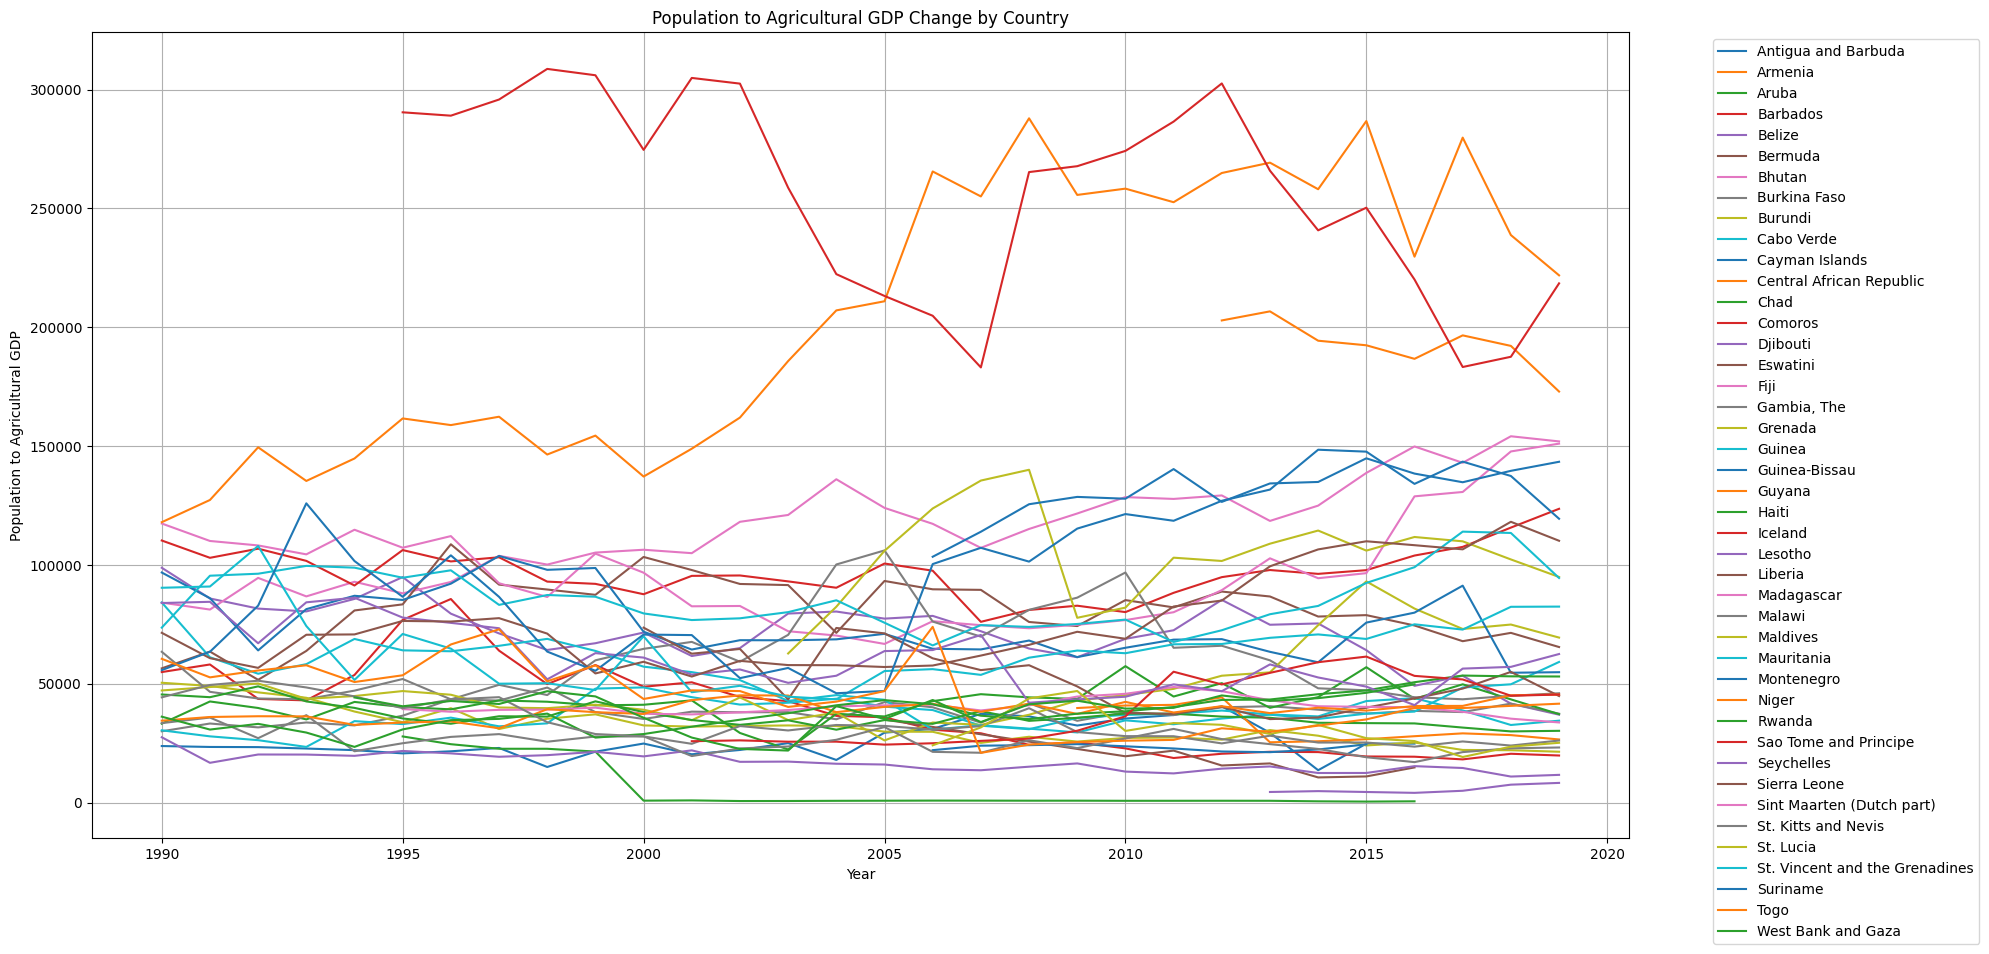

In [35]:
plt.figure(figsize=(20,10))

# higher cumulative co2 emission countries
for country in m_gdp_low.index:
    data = m_df.loc[m_df['country'] == country]
    plt.plot(data['year'], data['pop_to_ag_gdp'])

plt.xlabel('Year')
plt.ylabel('Population to Agricultural GDP')
plt.title('Population to Agricultural GDP Change by Country')
plt.grid(True)

# Place the legend outside the plot
plt.legend(m_gdp_low.index, bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

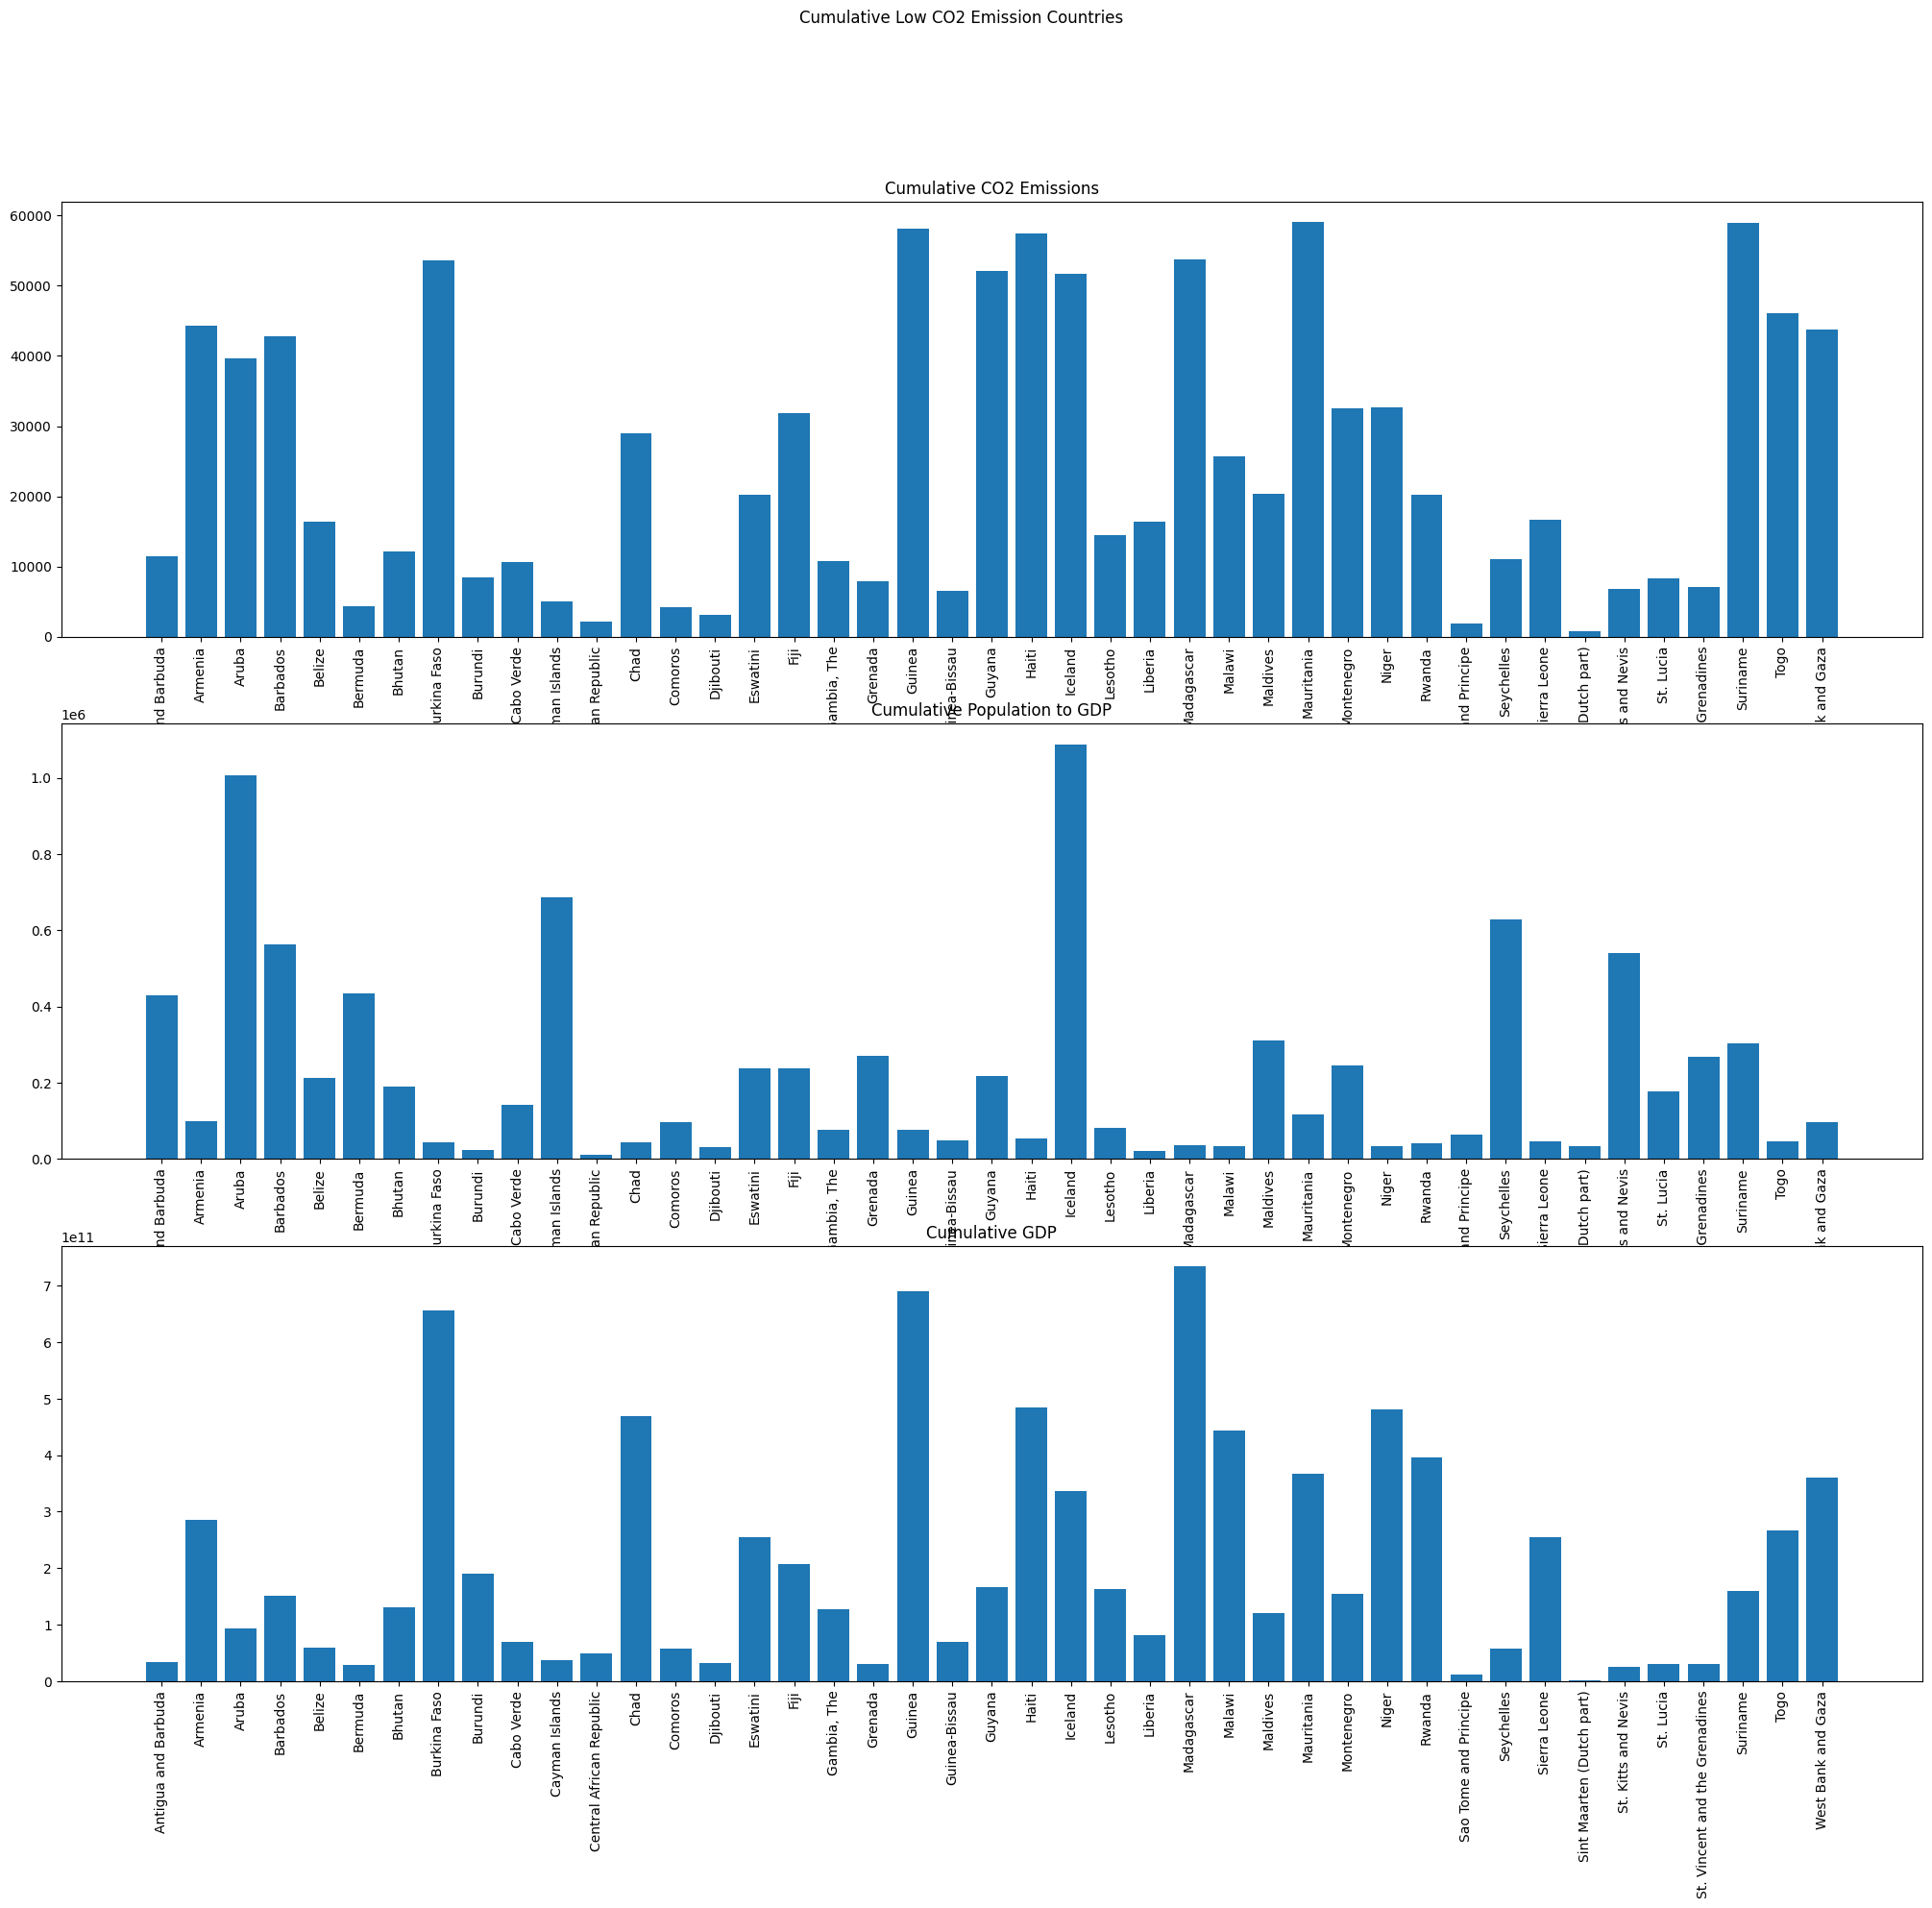

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,20))

fig.suptitle('Cumulative Low CO2 Emission Countries')

ax1.bar(m_gdp_low.index,m_gdp_low['co2_emissions'])
ax1.set_title('Cumulative CO2 Emissions')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2.bar(m_gdp_low.index,m_gdp_low['pop_to_gdp'])
ax2.set_title('Cumulative Population to GDP')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

ax3.bar(m_gdp_low.index,m_gdp_low['gdp'])
ax3.set_title('Cumulative GDP')
ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)

plt.show()

### Regression Analysis

**Notes**
- all data: weak r-squared values when comparing co2 emission to multiple for population to gdp
- used the country data where the cumulative co2 emission is within the iqr
   - gdp, pop_to_ag_gdp have good scatter plots and decent r-squared values
   - will try these two values with multiple linear regression 

In [37]:
# get data within IQR
iqr_cum_df = m_cumulative.loc[(m_cumulative["co2_emissions"] > m_summary["co2_emissions"]["25%"]) & (m_cumulative["co2_emissions"] < m_summary["co2_emissions"]["75%"])]

iqr_df = m_df.loc[m_df["country"].isin(iqr_cum_df.index)]

iqr_corr_matrix = iqr_df[["year","co2_emissions","pesticide_by_tonnes","population","ag_percent_gdp","gdp","ag_gdp","pop_to_gdp","pop_to_ag_gdp"]].corr().round(2)
iqr_corr_matrix

year  co2_emissions  pesticide_by_tonnes  population  \
year                 1.00           0.17                 0.17        0.09   
co2_emissions        0.17           1.00                 0.24        0.07   
pesticide_by_tonnes  0.17           0.24                 1.00        0.17   
population           0.09           0.07                 0.17        1.00   
ag_percent_gdp      -0.24          -0.38                -0.08        0.42   
gdp                  0.31           0.73                 0.27        0.30   
ag_gdp               0.16           0.17                 0.27        0.85   
pop_to_gdp           0.22           0.45                -0.07       -0.27   
pop_to_ag_gdp        0.10           0.22                 0.23       -0.13   

                     ag_percent_gdp   gdp  ag_gdp  pop_to_gdp  pop_to_ag_gdp  
year                          -0.24  0.31    0.16        0.22           0.10  
co2_emissions                 -0.38  0.73    0.17        0.45           0.22  
pesticide_by_tonnes           -0.08  0.27    0.27       -0.07           0.23  
population                     0.42  0.30    0.85       -0.27          -0.13  
ag_percent_gdp                 1.00 -0.28    0.44       -0.55           0.07  
gdp                           -0.28  1.00    0.37        0.49           0.11  
ag_gdp                         0.44  0.37    1.00       -0.26           0.19  
pop_to_gdp                    -0.55  0.49   -0.26        1.00          -0.00  
pop_to_ag_gdp                  0.07  0.11    0.19       -0.00           1.00

##### Linear Regression Analysis

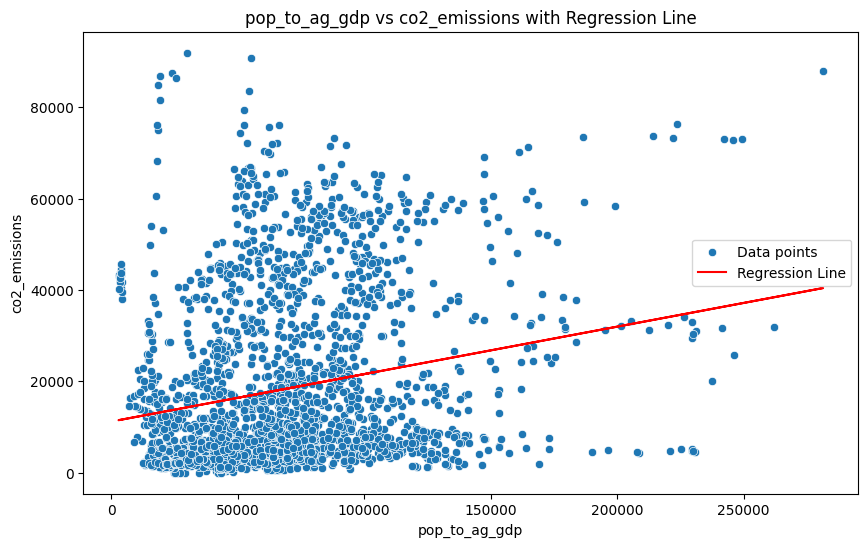

Slope (Coefficient): 0.1038737321133593
Intercept: 11179.018260575413
---
R-squared value: 0.05043987740578615
mean_squared_error :  335108400.4829512


In [38]:
variable_to_test = "pop_to_ag_gdp"
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test].values.reshape(-1, 1)
y = iqr_df[outcome_to_test].values

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
test = pd.DataFrame(X_test)

# plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=iqr_df[variable_to_test], y=iqr_df[outcome_to_test], label='Data points')
plt.plot(test[0], predictions, color="red", label="Regression Line")
plt.title(f"{variable_to_test} vs {outcome_to_test} with Regression Line")
plt.ylabel(outcome_to_test)
plt.xlabel(variable_to_test)
plt.legend()
plt.show()

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

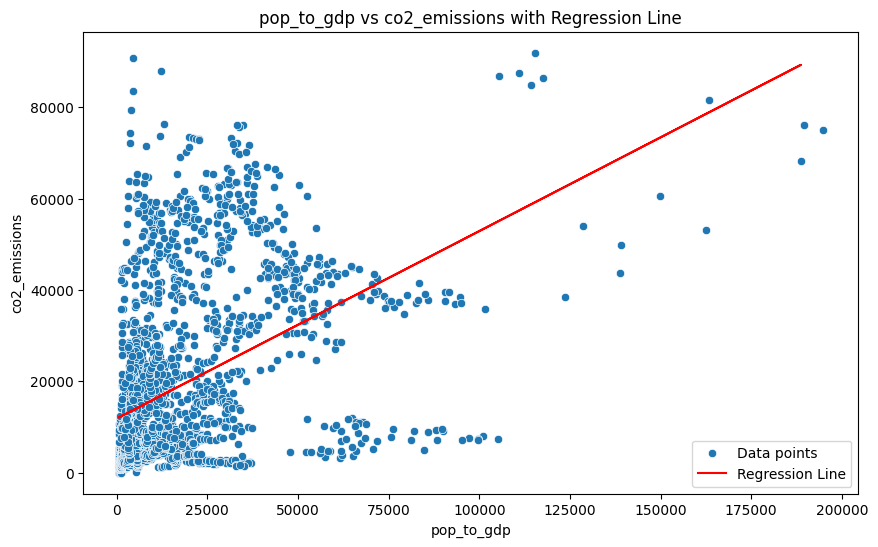

Slope (Coefficient): 0.41037912527701015
Intercept: 11841.816136393054
---
R-squared value: 0.19992326023077367
mean_squared_error :  289297244.5034844


In [39]:
variable_to_test = "pop_to_gdp"
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test].values.reshape(-1, 1)
y = iqr_df[outcome_to_test].values

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
test = pd.DataFrame(X_test)

# plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=iqr_df[variable_to_test], y=iqr_df[outcome_to_test], label='Data points')
plt.plot(test[0], predictions, color="red", label="Regression Line")
plt.title(f"{variable_to_test} vs {outcome_to_test} with Regression Line")
plt.ylabel(outcome_to_test)
plt.xlabel(variable_to_test)
plt.legend()
plt.show()

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

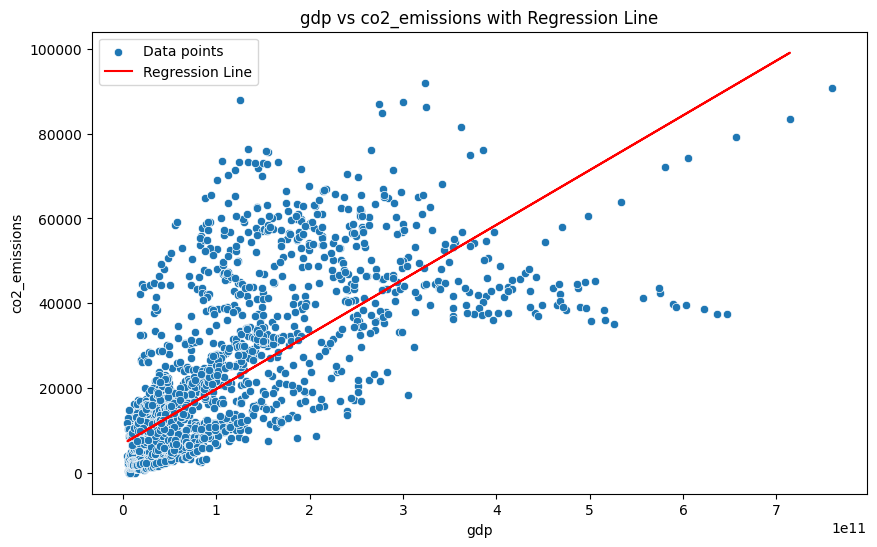

Slope (Coefficient): 1.2918198679549592e-07
Intercept: 6801.916602335901
---
R-squared value: 0.5267473961882544
mean_squared_error :  170137785.18835554


In [40]:
variable_to_test = "gdp"
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test].values.reshape(-1, 1)
y = iqr_df[outcome_to_test].values

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
test = pd.DataFrame(X_test)

# plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=iqr_df[variable_to_test], y=iqr_df[outcome_to_test], label='Data points')
plt.plot(test[0], predictions, color="red", label="Regression Line")
plt.title(f"{variable_to_test} vs {outcome_to_test} with Regression Line")
plt.ylabel(outcome_to_test)
plt.xlabel(variable_to_test)
plt.legend()
plt.show()

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

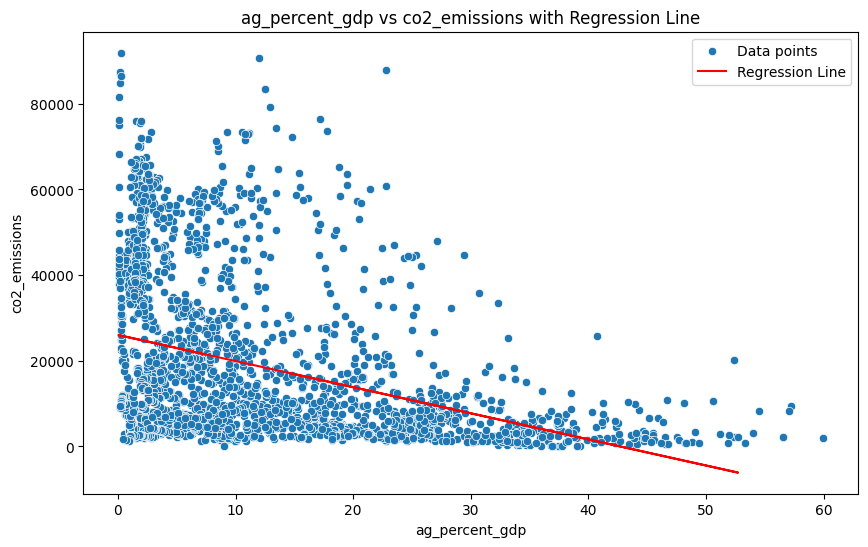

Slope (Coefficient): -610.0730946458816
Intercept: 26006.722954123026
---
R-squared value: 0.1475885535524334
mean_squared_error :  305702328.94708914


In [41]:
variable_to_test = "ag_percent_gdp"
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test].values.reshape(-1, 1)
y = iqr_df[outcome_to_test].values

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
test = pd.DataFrame(X_test)

# plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=iqr_df[variable_to_test], y=iqr_df[outcome_to_test], label='Data points')
plt.plot(test[0], predictions, color="red", label="Regression Line")
plt.title(f"{variable_to_test} vs {outcome_to_test} with Regression Line")
plt.ylabel(outcome_to_test)
plt.xlabel(variable_to_test)
plt.legend()
plt.show()

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

##### Multiple Linear Regression

In [42]:
variable_to_test = ["population", "gdp"]
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test]
y = iqr_df[outcome_to_test]

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient): {model.coef_[0]}")
print(f"    coefficient for {variable_to_test[0]}: {model.coef_[0]}")
print(f"    coefficient for {variable_to_test[1]}: {model.coef_[1]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

Slope (Coefficient): -0.0001509171930948778
    coefficient for population: -0.0001509171930948778
    coefficient for gdp: 1.3769925228142612e-07
Intercept: 7978.803967386024
---
R-squared value: 0.5507494852341487
mean_squared_error :  305702328.94708914


**Interpretation** Population and GDP appears to be a good indicator of CO2 emissions -- 55% of the variation in CO2 emissions can be explained by population and GDP. </br></br> One concern of the analysis is the large MSE value.

##### **[KEEP]** Multiple Linear Regression: Population, GDP, Population to GDP & Agricultural % GDP

Slope (Coefficient):
    coefficient for population: -0.0001322769852227934
    coefficient for gdp: 1.344443327415779e-07
    coefficient for pop_to_ag_gdp: 0.055513248750109136
Intercept: 4199.878130727608
---
R-squared value: 0.5652721727600301
mean_squared_error :  156305120.04485583


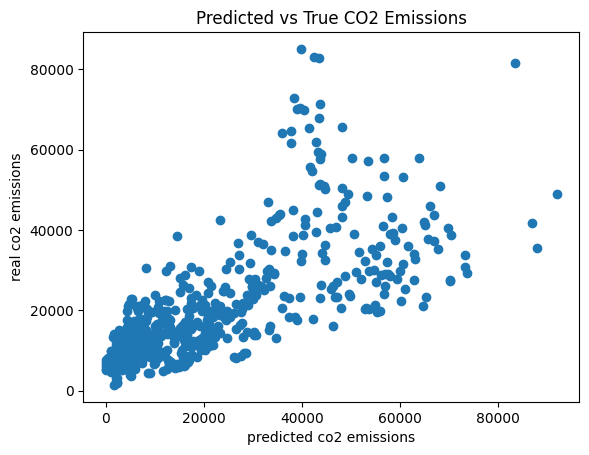

In [43]:
#variable_to_test = ["population", "gdp", "pop_to_ag_gdp", "ag_percent_gdp"]
variable_to_test = ["population", "gdp", "pop_to_ag_gdp"]
outcome_to_test = "co2_emissions"

# reshape the data for sklearn
X = iqr_df[variable_to_test]
y = iqr_df[outcome_to_test]

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train)

# making predictions 
predictions = model.predict(X_test) 
test = pd.DataFrame(X_test)

# print the slope (coefficient) and intercept of the regression line
print(f"Slope (Coefficient):")
print(f"    coefficient for {variable_to_test[0]}: {model.coef_[0]}")
print(f"    coefficient for {variable_to_test[1]}: {model.coef_[1]}")
print(f"    coefficient for {variable_to_test[2]}: {model.coef_[2]}")
#print(f"    coefficient for {variable_to_test[3]}: {model.coef_[3]}")
print(f"Intercept: {model.intercept_}")
print(f"---")

# model evaluation
r_squared = model.score(X, y)
print(f"R-squared value: {r_squared}")
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 

# plot the test outcomes to the predicted outcomes
plt.scatter(y_test, predictions, marker="o")
plt.title("Predicted vs True CO2 Emissions")
plt.xlabel("predicted co2 emissions")
plt.ylabel("real co2 emissions")
plt.show()

**Interpretation** Population and gross dometic product (GDP) appears to be a good indicator of CO2 emissions -- 57% of the variation in CO2 emissions can be explained by population, and the multiple for population to agricultural GDP. </br></br> One concern of the analysis is the large MSE value.

##### Additional Analysis on IQR Countries

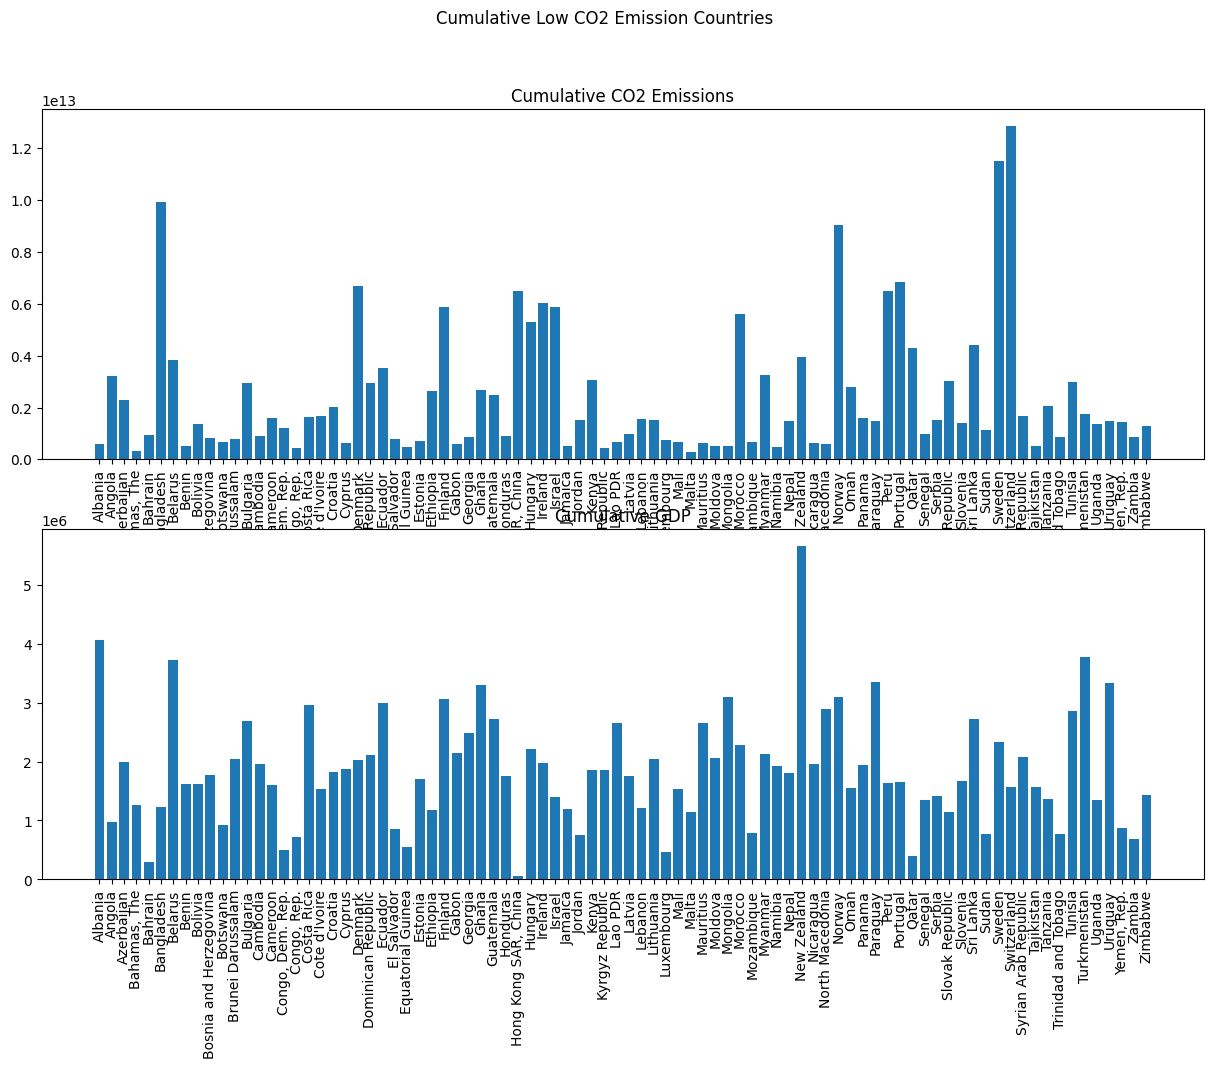

In [44]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,20))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle('Cumulative Low CO2 Emission Countries')

ax1.bar(iqr_cum_df.index,iqr_cum_df[variable_to_test[1]])
ax1.set_title("Cumulative CO2 Emissions")
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2.bar(iqr_cum_df.index,iqr_cum_df[variable_to_test[2]])
ax2.set_title("Cumulative GDP")
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

#ax3.bar(iqr_cum_df.index,iqr_cum_df[variable_to_test[3]])
#ax3.set_title("Cumulative Multiple of Population to Agricultural GDP")
#ax3.set_xticks(ax3.get_xticks())
#ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)

plt.show()

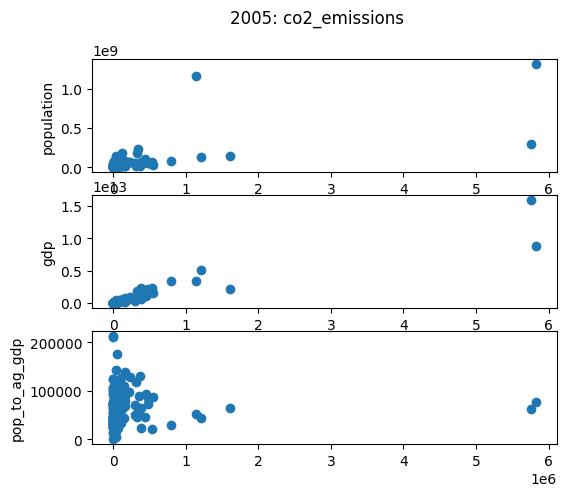

In [45]:
# scatter plot with subset of year
year = 2005
test_df = m_df.loc[m_df["year"] == year]

#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,5))

fig.suptitle(f"{year}: {outcome_to_test}")

ax1.scatter(test_df[outcome_to_test],test_df[variable_to_test[0]],marker="o")
ax1.set_ylabel(f"{variable_to_test[0]}")

ax2.scatter(test_df[outcome_to_test],test_df[variable_to_test[1]],marker="o")
ax2.set_ylabel(f"{variable_to_test[1]}")

ax3.scatter(test_df[outcome_to_test],test_df[variable_to_test[2]],marker="o")
ax3.set_ylabel(f"{variable_to_test[2]}")

#ax4.scatter(test_df[outcome_to_test],test_df[variable_to_test[3]],marker="o")
#ax4.set_ylabel(f"{variable_to_test[3]}")
#ax4.set_ylabel(f"{outcome_to_test}")

plt.show()

#### Correlation Matrix

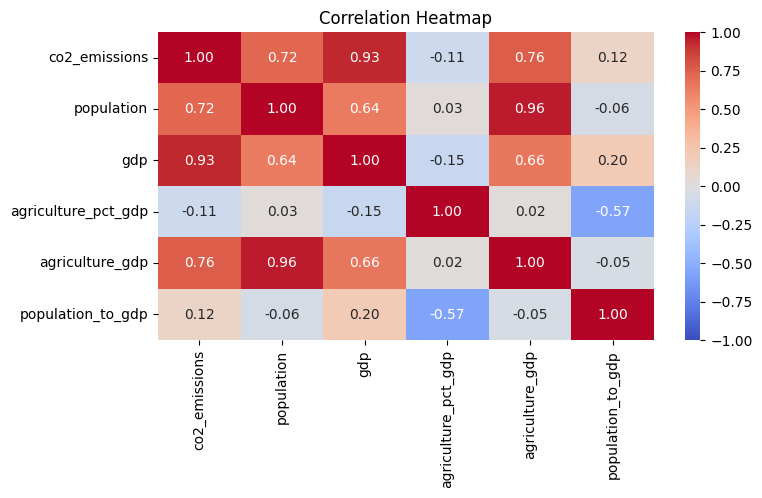

In [68]:
m_correlation_data = m_df[["co2_emissions","population","gdp","ag_percent_gdp","ag_gdp","pop_to_gdp"]]
m_correlation_data = m_correlation_data.rename(columns={
    "ag_percent_gdp":"agriculture_pct_gdp",
    "ag_gdp":"agriculture_gdp",
    "pop_to_gdp":"population_to_gdp"
})
correlation_matrix = m_correlation_data.corr().round(2)

# Generate a heatmap
plt.figure(figsize=(8,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')

# Save and show the plot
plt.title('Correlation Heatmap')
plt.savefig('Images/Correlation-Heatmap-CO2-Population-GDP.png')
plt.show()